Import library

In [81]:
from ucimlrepo import fetch_ucirepo 
from scipy.stats import boxcox
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import LinearRegression
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
import numpy as np
import shutil
import math

Import Data

In [82]:
# Fetch dataset 
support2 = fetch_ucirepo(id=880) 

# Data (as pandas dataframes) 
X = support2.data.features 
y = support2.data.targets 

# Combine features and targets into a single DataFrame, if desired
df = pd.concat([X, y], axis=1)

# # Save to CSV
# df.to_csv('output.csv', index=False)

# # Move the file to a location where it can be accessed/downloaded
# shutil.move('output.csv', 'csv')

# metadata 
print(support2.metadata) 

# variable information 
print(support2.variables)

df = pd.read_csv('data.csv', header = None)
df.columns = ['id','age','death','sex','hospdead','slos','d.time','dzgroup','dzclass','num.co','edu','income','scoma','charges','totcst','totmcst','avtisst','race','sps','aps','surv2m','surv6m','hday','diabetes','dementia','ca','prg2m','prg6m','dnr','dnrday','meanbp','wblc','hrt','resp','temp','pafi','alb','bili','crea','sod','ph','glucose','bun','urine','adlp','adls','sfdm2','adlsc']
# นับจำนวนคอลัมน์ทั้งหมด
num_columns = len(df.columns)
# แสดงผลลัพธ์
print(f"จำนวนคอลัมน์ทั้งหมด: {num_columns}")
df.head()


{'uci_id': 880, 'name': 'SUPPORT2', 'repository_url': 'https://archive.ics.uci.edu/dataset/880/support2', 'data_url': 'https://archive.ics.uci.edu/static/public/880/data.csv', 'abstract': "This dataset comprises 9105 individual critically ill patients across 5 United States medical centers, accessioned throughout 1989-1991 and 1992-1994.\nEach row concerns hospitalized patient records who met the inclusion and exclusion criteria for nine disease categories: acute respiratory failure, chronic obstructive pulmonary disease, congestive heart failure, liver disease, coma, colon cancer, lung cancer, multiple organ system failure with malignancy, and multiple organ system failure with sepsis. The goal is to determine these patients' 2- and 6-month survival rates based on several physiologic, demographics, and disease severity information. \nIt is an important problem because it addresses the growing national concern over patients' loss of control near the end of life. It enables earlier deci

id       age  death     sex  hospdead  slos  d.time      dzgroup  \
0  id       age  death     sex  hospdead  slos  d.time      dzgroup   
1   1  62.84998      0    male         0     5    2029  Lung Cancer   
2   2  60.33899      1  female         1     4       4    Cirrhosis   
3   3  52.74698      1  female         0    17      47    Cirrhosis   
4   4  42.38498      1  female         0     3     133  Lung Cancer   

              dzclass  num.co  ...        crea  sod        ph  glucose  bun  \
0             dzclass  num.co  ...        crea  sod        ph  glucose  bun   
1              Cancer       0  ...  1.19995117  141  7.459961      NaN  NaN   
2  COPD/CHF/Cirrhosis       2  ...         5.5  132      7.25      NaN  NaN   
3  COPD/CHF/Cirrhosis       2  ...           2  134  7.459961      NaN  NaN   
4              Cancer       2  ...  0.79992676  139       NaN      NaN  NaN   

   urine  adlp  adls                sfdm2  adlsc  
0  urine  adlp  adls                sfdm2  adlsc  
1    NaN     7     7                  NaN      7  
2    NaN   NaN     1     <2 mo. follow-up      1  
3    NaN     1     0     <2 mo. follow-up      0  
4    NaN     0     0  no(M2 and SIP pres)      0  

[5 rows x 48 columns]

กำหนด Taget variable

In [3]:
# กำหนด Target variable
target_variable = pd.to_numeric(df['charges'], errors='coerce')

Cleaning Data

ตัด column ที่มี missing value มากกว่า 40% และตัด row ที่มี missing value มากกว่า 30% เพราะปริมาณข้อมูลที่สูญหายมากเกินไป จึงไม่สามารถใช้วิธีนำมาเติม Missing Value ได้

In [83]:
# เก็บจำนวนคอลัมน์และแถวก่อนการลบ
cols_before = df.columns
rows_before = df.shape[0]

# ลบคอลัมน์ที่มีค่าหายไปมากกว่า 40%
df = df.loc[:, df.isnull().mean() < 0.4]
cols_after = df.columns

# ลบแถวที่มีค่าหายไปมากกว่า 30%
df = df.dropna(thresh=len(df.columns) * 0.7)
rows_after = df.shape[0]

# คำนวณจำนวนคอลัมน์ที่ถูกลบออก
cols_dropped = set(cols_before) - set(cols_after)

# คำนวณจำนวนแถวที่ถูกลบ
rows_dropped = rows_before - rows_after

# แสดงผลลัพธ์
print("cols_before : ",cols_before)
print("cols_After : ",cols_after)
print("คอลัมน์ที่ถูกลบ:")
print(cols_dropped)

print("\nคอลัมน์ที่ยังคงอยู่:")
print(df.columns)
print(f"\nจำนวนแถวที่ถูกลบ: {rows_dropped}")
# แสดงข้อมูลตัวอย่าง
print("\nข้อมูลตัวอย่างหลังการลบ:")

# # Remove non-numeric columns
# numeric_df = df.select_dtypes(include=[np.number])
df.head()


cols_before :  Index(['id', 'age', 'death', 'sex', 'hospdead', 'slos', 'd.time', 'dzgroup',
       'dzclass', 'num.co', 'edu', 'income', 'scoma', 'charges', 'totcst',
       'totmcst', 'avtisst', 'race', 'sps', 'aps', 'surv2m', 'surv6m', 'hday',
       'diabetes', 'dementia', 'ca', 'prg2m', 'prg6m', 'dnr', 'dnrday',
       'meanbp', 'wblc', 'hrt', 'resp', 'temp', 'pafi', 'alb', 'bili', 'crea',
       'sod', 'ph', 'glucose', 'bun', 'urine', 'adlp', 'adls', 'sfdm2',
       'adlsc'],
      dtype='object')
cols_After :  Index(['id', 'age', 'death', 'sex', 'hospdead', 'slos', 'd.time', 'dzgroup',
       'dzclass', 'num.co', 'edu', 'income', 'scoma', 'charges', 'totcst',
       'totmcst', 'avtisst', 'race', 'sps', 'aps', 'surv2m', 'surv6m', 'hday',
       'diabetes', 'dementia', 'ca', 'prg2m', 'prg6m', 'dnr', 'dnrday',
       'meanbp', 'wblc', 'hrt', 'resp', 'temp', 'pafi', 'alb', 'bili', 'crea',
       'sod', 'ph', 'adls', 'sfdm2', 'adlsc'],
      dtype='object')
คอลัมน์ที่ถูกลบ:
{'urine', 

id       age  death     sex  hospdead  slos  d.time      dzgroup  \
0  id       age  death     sex  hospdead  slos  d.time      dzgroup   
1   1  62.84998      0    male         0     5    2029  Lung Cancer   
2   2  60.33899      1  female         1     4       4    Cirrhosis   
3   3  52.74698      1  female         0    17      47    Cirrhosis   
4   4  42.38498      1  female         0     3     133  Lung Cancer   

              dzclass  num.co  ...      temp       pafi        alb  \
0             dzclass  num.co  ...      temp       pafi        alb   
1              Cancer       0  ...        36        388  1.7998047   
2  COPD/CHF/Cirrhosis       2  ...  34.59375         98        NaN   
3  COPD/CHF/Cirrhosis       2  ...  37.39844  231.65625        NaN   
4              Cancer       2  ...        35        NaN        NaN   

         bili        crea  sod        ph  adls                sfdm2  adlsc  
0        bili        crea  sod        ph  adls                sfdm2  adlsc  
1  0.19998169  1.19995117  141  7.459961     7                  NaN      7  
2         NaN         5.5  132      7.25     1     <2 mo. follow-up      1  
3  2.19970703           2  134  7.459961     0     <2 mo. follow-up      0  
4         NaN  0.79992676  139       NaN     0  no(M2 and SIP pres)      0  

[5 rows x 44 columns]

In [61]:
print(df.dtypes)

id          object
age         object
death       object
sex         object
hospdead    object
slos        object
d.time      object
dzgroup     object
dzclass     object
num.co      object
edu         object
income      object
scoma       object
charges     object
totcst      object
totmcst     object
avtisst     object
race        object
sps         object
aps         object
surv2m      object
surv6m      object
hday        object
diabetes    object
dementia    object
ca          object
prg2m       object
prg6m       object
dnr         object
dnrday      object
meanbp      object
wblc        object
hrt         object
resp        object
temp        object
pafi        object
alb         object
bili        object
crea        object
sod         object
ph          object
adls        object
sfdm2       object
adlsc       object
dtype: object


Change to Numeric 

เปลี่ยน data ที่ยังเป็น type อื่นที่ไม่ใช่  numeric ให้เป็น numeric

In [84]:
categorical_columns = ['sex','income','race','ca', 'dzgroup', 'dzclass', 'dnr' , 'sfdm2'] 
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))  # Convert to string if not already
    label_encoders[col] = le
print(f"Categorical columns: {categorical_columns}")
df[categorical_columns].head()
# df.head()

Categorical columns: ['sex', 'income', 'race', 'ca', 'dzgroup', 'dzclass', 'dnr', 'sfdm2']


sex  income  race  ca  dzgroup  dzclass  dnr  sfdm2
0    2       3     5   0        8        4    0      6
1    1       0     4   1        6        2    4      4
2    0       0     6   2        3        1    3      0
3    0       5     6   2        3        1    4      0
4    0       5     6   1        6        2    4      5

แปลง data ที่เป็น string ของตัวเลขให้เป็น numeric 

In [85]:
# แปลงคอลัมน์ที่ควรเป็นตัวเลขทั้งหมด
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')  # แปลงเป็นตัวเลข ถ้าไม่สามารถแปลงได้จะกลายเป็น NaN


Missing Value 

จัดการข้อมูลที่หายไปโดยหา method ที่ดีที่สุดของแต่ละคอลัมมาเติม Missing value 
- mean
- mode
- hot-deck
- Nearest Neighbor
- Regression


In [86]:
# ฟังก์ชันสำหรับ hot-deck imputation (ใช้ KNN)
def hot_deck_imputation(X_train, X_test):
    imputer = KNNImputer(n_neighbors=5)
    X_train_imputed = imputer.fit_transform(X_train)
    X_test_imputed = imputer.transform(X_test)
    return X_train_imputed, X_test_imputed

In [79]:
def evaluate_imputation(method, df, target_col='charges'):
    # แบ่งข้อมูลเป็นชุดฝึกและชุดทดสอบ
    df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
    
    X_train = df_train.drop(columns=[target_col])
    y_train = df_train[target_col]
    
    X_test = df_test.drop(columns=[target_col])
    y_test = df_test[target_col]
    
    # Handle missing values in the target variable
    y_train = pd.to_numeric(y_train, errors='coerce')  # แปลงให้เป็นตัวเลข
    y_test = pd.to_numeric(y_test, errors='coerce')

    y_train = y_train.fillna(y_train.mean())
    y_test = y_test.fillna(y_test.mean())
    
    if method == 'mean':
        imputer = SimpleImputer(strategy='mean')
        X_train_imputed = imputer.fit_transform(X_train)
        X_test_imputed = imputer.transform(X_test)

    elif method == 'mode':
        imputer = SimpleImputer(strategy='most_frequent')
        X_train_imputed = imputer.fit_transform(X_train)
        X_test_imputed = imputer.transform(X_test)
        
    elif method == 'hot_deck':
        # Hot-deck Imputation (Using KNN)
        X_train_imputed, X_test_imputed = hot_deck_imputation(X_train, X_test)
    
    # elif method == 'regression':
    #     # Normal Regression (predict target directly)
    #     # แปลง X_train และ X_test ให้เป็น 2D array ถ้าจำเป็น
    #     if len(X_train.shape) == 1:
    #         X_train = X_train.reshape(-1, 1)
    #     if len(X_test.shape) == 1:
    #         X_test = X_test.reshape(-1, 1)
        
    #     model = LinearRegression()
    #     model.fit(X_train, y_train)
    #     y_pred = model.predict(X_test)
    #     mse = mean_squared_error(y_test, y_pred)
    #     return mse
    
    elif method == 'nearest_neighbor':
        # Nearest Neighbor (KNNImputer)
        imputer = KNNImputer(n_neighbors=5)
        X_train_imputed = imputer.fit_transform(X_train)
        X_test_imputed = imputer.transform(X_test)

    else:
        raise ValueError(f"Unknown method: {method}")

    # Train a Linear Regression model
    model = LinearRegression()
    model.fit(X_train_imputed, y_train)
    
    # Predict and calculate MSE
    y_pred = model.predict(X_test_imputed)
    mse = mean_squared_error(y_test, y_pred)
    
    return mse

หา method ที่ดีที่สุดในการเติม missing value (ยังไม่สามารถใช้  Regression เพราะว่ายังไม่มี คอลัมม์ที่สมบูรณ์มาใช้เปรียบเทียบ)

In [89]:
# รายการวิธีการที่จะทดสอบ 
methods = ['mean', 'mode', 'hot_deck', 'nearest_neighbor']
results = {}

# สร้างสำเนาข้อมูลเพื่อเติมค่า
df_filled = df.copy()

# วนลูปทีละคอลัมน์ใน df ยกเว้นคอลัมน์เป้าหมาย 'charges'
for col in df.columns:
    print(f"\nTesting column: {col}")
    results[col] = {}

    # วนลูปทดสอบแต่ละวิธีการเติมค่าที่หายไป
    for method in methods:
        try:
            print(f"  Method: {method}")
            mse = evaluate_imputation(method, df, target_col=col)
            results[col][method] = mse
            print(f"    MSE: {mse}")
        except ValueError as e:
            print(f"    Error with method {method}: {e}")

    # หาวิธีที่ดีที่สุดที่มีค่า MSE ต่ำที่สุด
    best_method = min(results[col], key=results[col].get)
    print(f"Best method for {col}: {best_method}")

    # เติมค่า Missing Value ใน df_filled สำหรับคอลัมน์นั้นด้วยวิธีที่ดีที่สุด
    if best_method == 'mean':
        imputer = SimpleImputer(strategy='mean')
    elif best_method == 'mode':
        imputer = SimpleImputer(strategy='most_frequent')
    elif best_method == 'hot_deck':
        imputer = KNNImputer(n_neighbors=5)
    elif best_method == 'nearest_neighbor':
        imputer = KNNImputer(n_neighbors=5)

    # เติมค่าในคอลัมน์นั้นๆ
    df_filled[col] = df_filled[col].mask(df_filled[col].isna(), imputer.fit_transform(df[[col]]).flatten())

# บันทึกผลลัพธ์ลงในไฟล์ CSV
output_file = 'filled_data.csv'
df_filled.to_csv(output_file, index=False)
shutil.move('filled_data.csv', 'csv')
print(f"\nCompleted filling missing values. Results saved to {output_file}")


Testing column: id
  Method: mean
    MSE: 5248006.048340225
  Method: mode
    MSE: 5065993.8700022185
  Method: hot_deck
    MSE: 5306635.2672875775
  Method: nearest_neighbor
    MSE: 5306635.2672875775
Best method for id: mode

Testing column: age
  Method: mean
    MSE: 128.0876235051285
  Method: mode
    MSE: 128.54946611971738
  Method: hot_deck
    MSE: 128.09534816280456
  Method: nearest_neighbor
    MSE: 128.09534816280456
Best method for age: mean

Testing column: death
  Method: mean
    MSE: 0.09636628484036434
  Method: mode
    MSE: 0.09518936280589188
  Method: hot_deck
    MSE: 0.09565193512161184
  Method: nearest_neighbor
    MSE: 0.09565193512161184
Best method for death: mode

Testing column: sex
  Method: mean
    MSE: 0.2414253075638775
  Method: mode
    MSE: 0.24155892417087566
  Method: hot_deck
    MSE: 0.2417191818014922
  Method: nearest_neighbor
    MSE: 0.2417191818014922
Best method for sex: mean

Testing column: hospdead
  Method: mean
    MSE: 0.060

Plot Histogram of Feature 

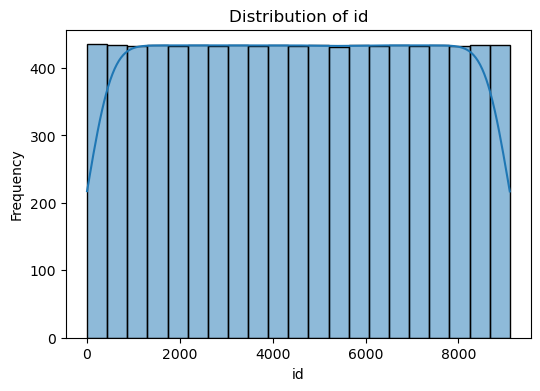

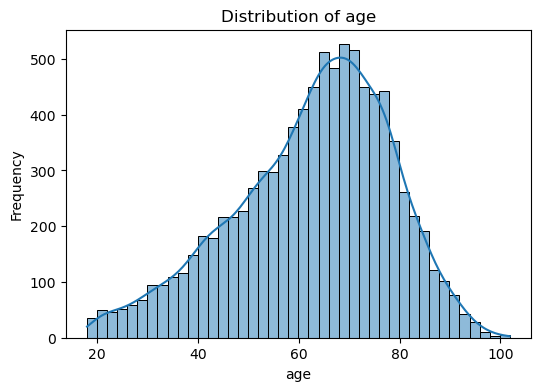

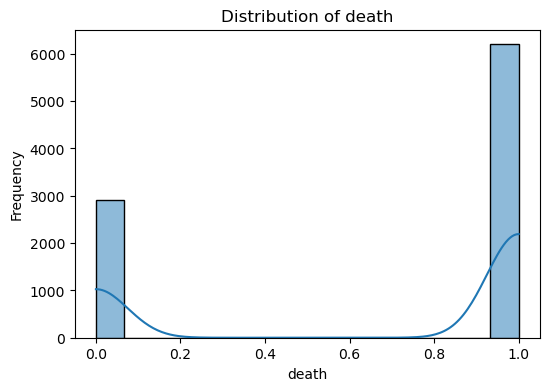

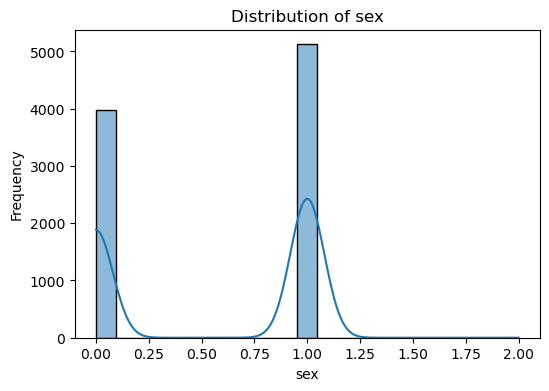

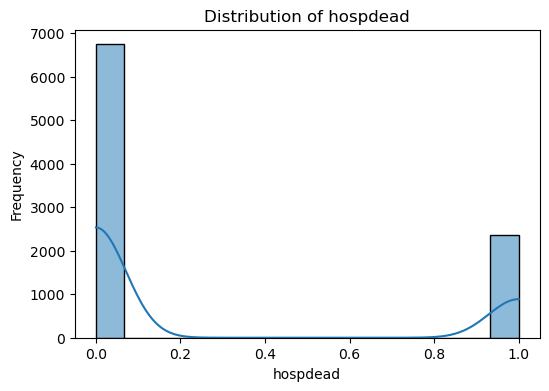

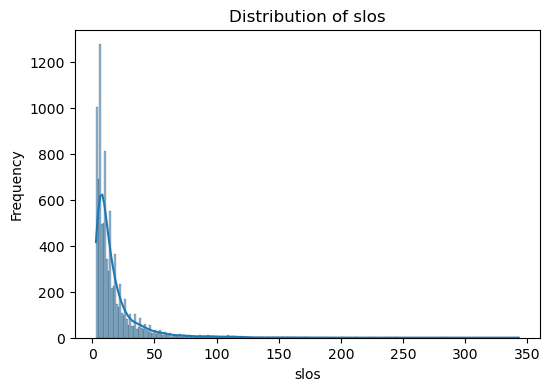

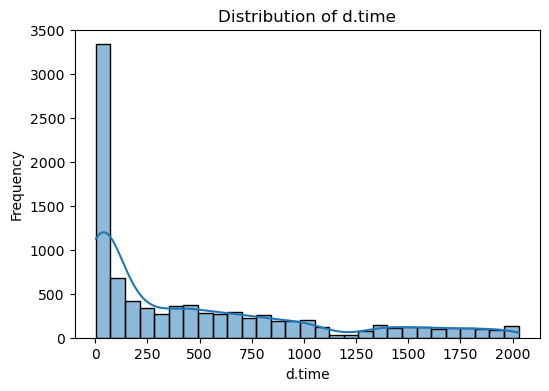

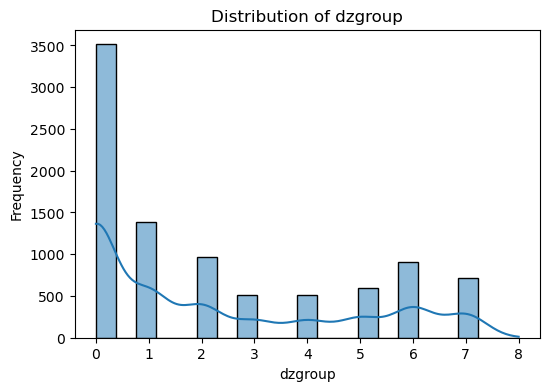

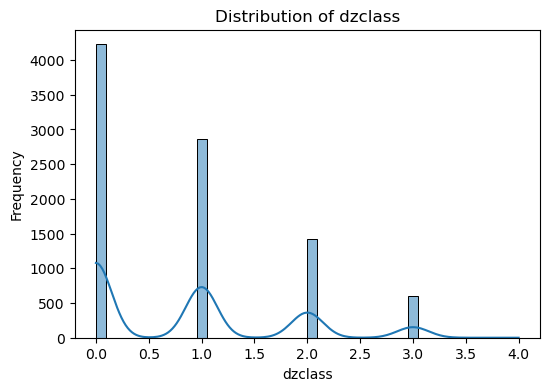

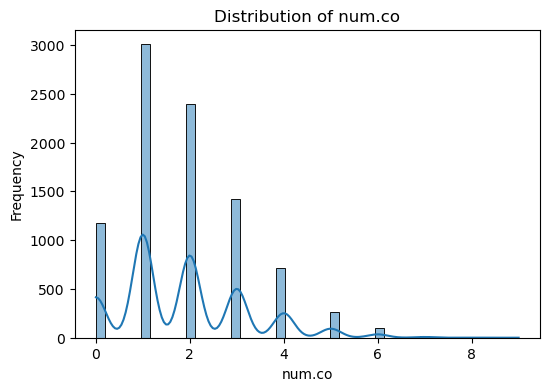

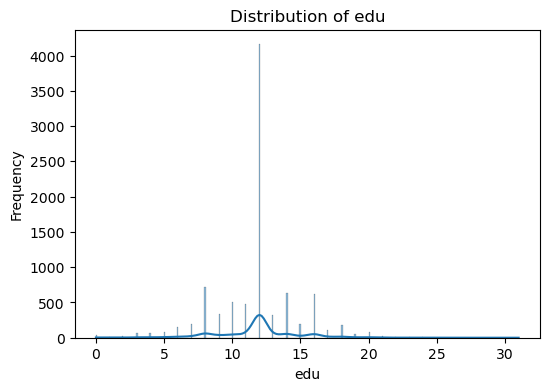

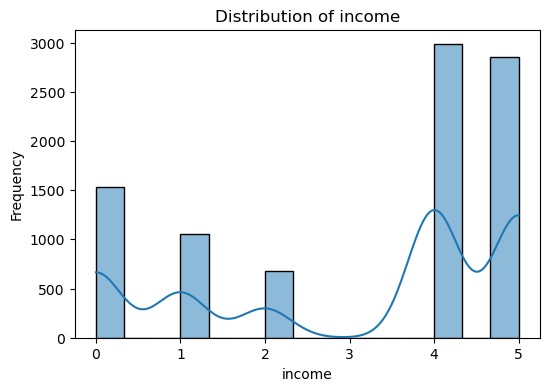

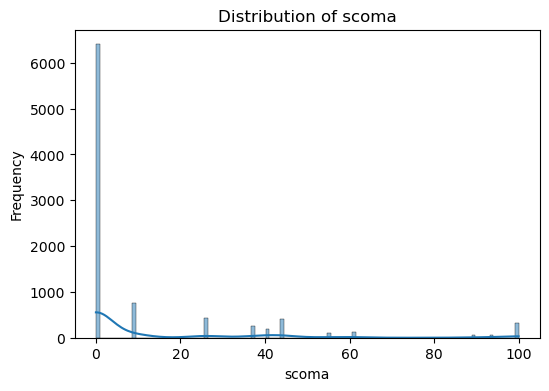

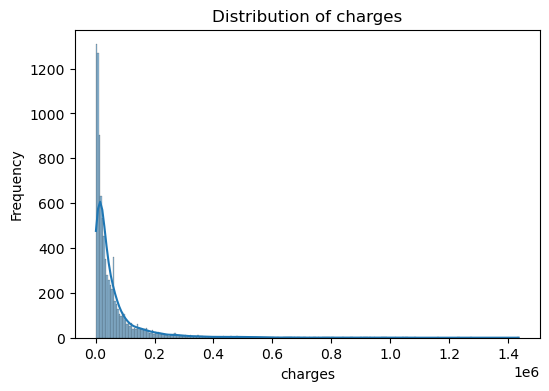

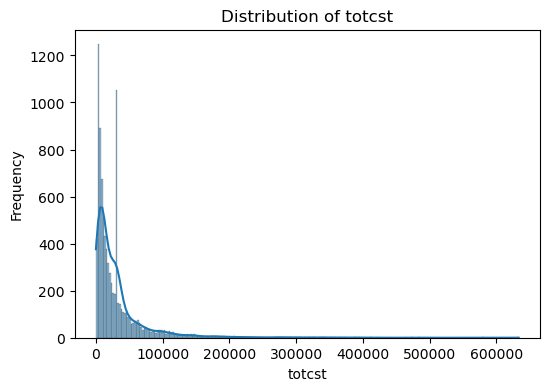

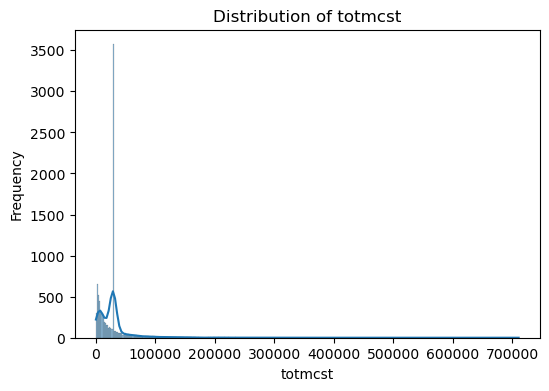

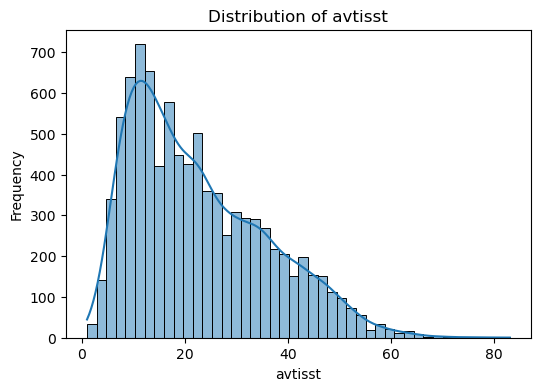

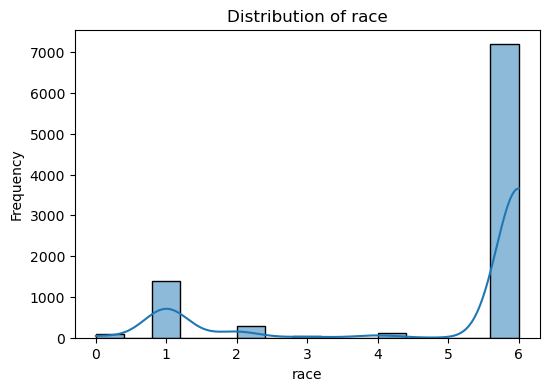

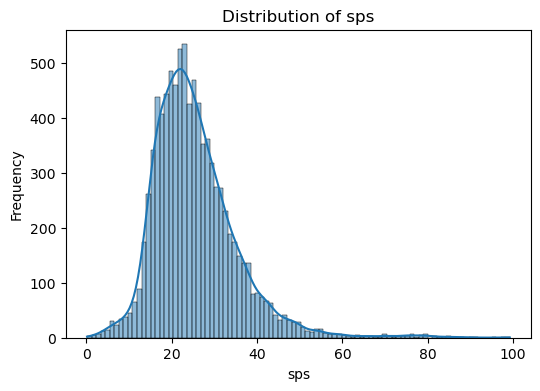

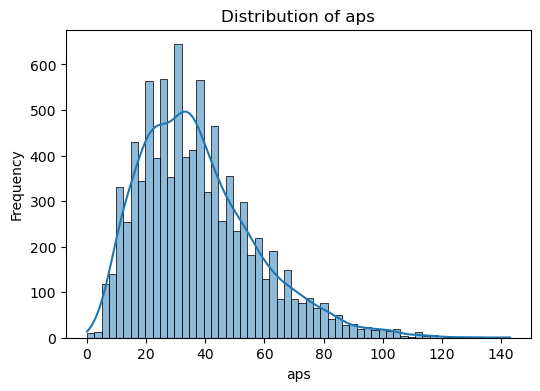

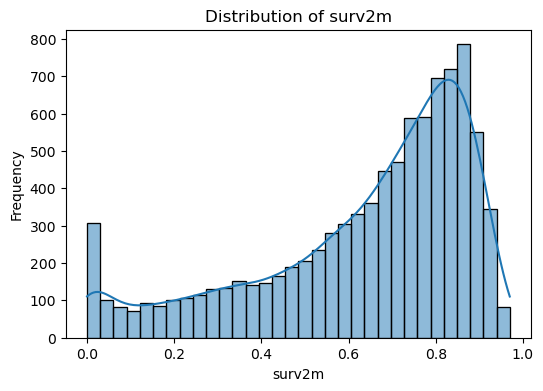

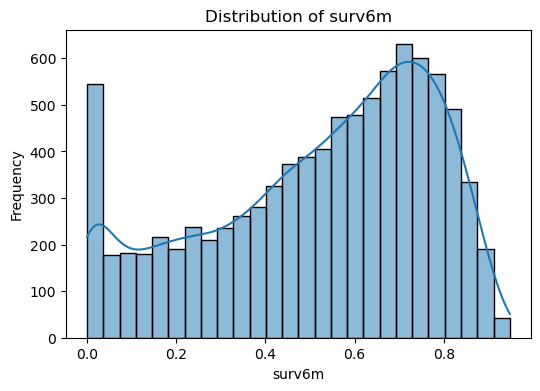

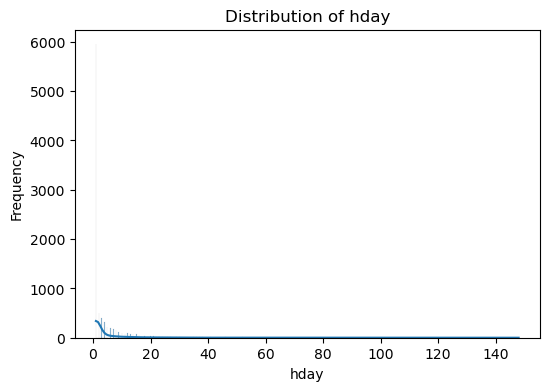

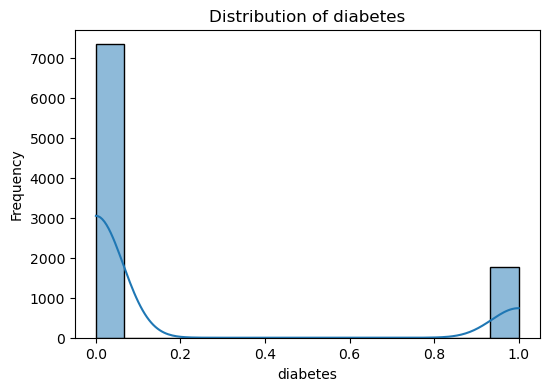

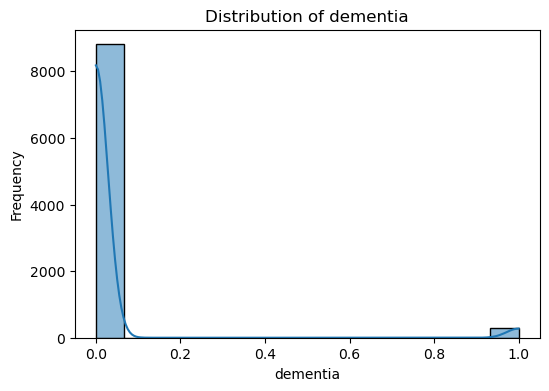

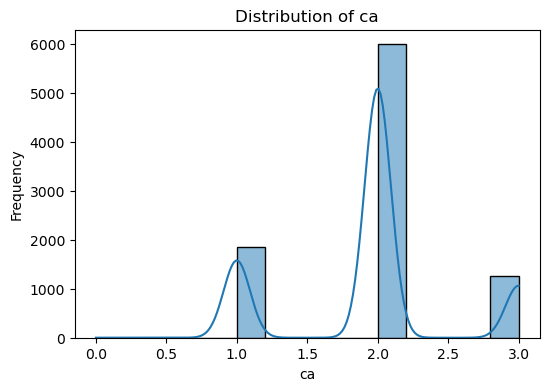

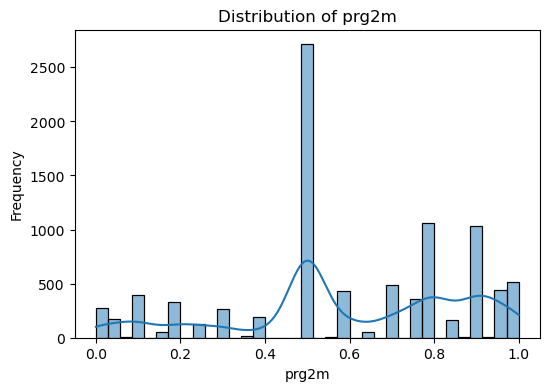

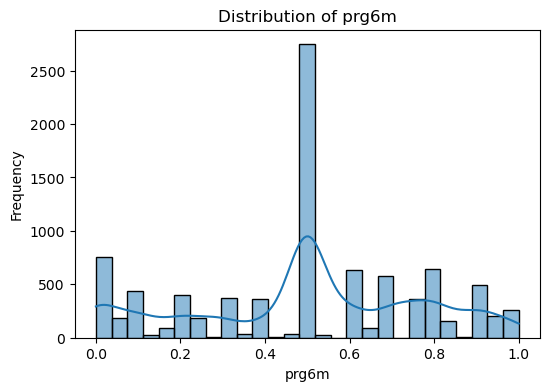

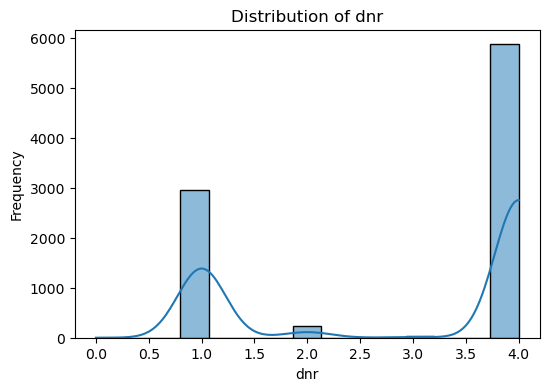

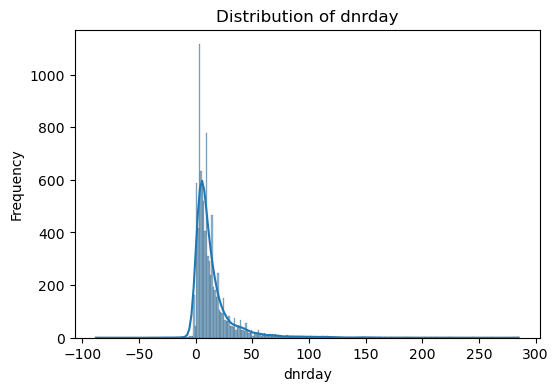

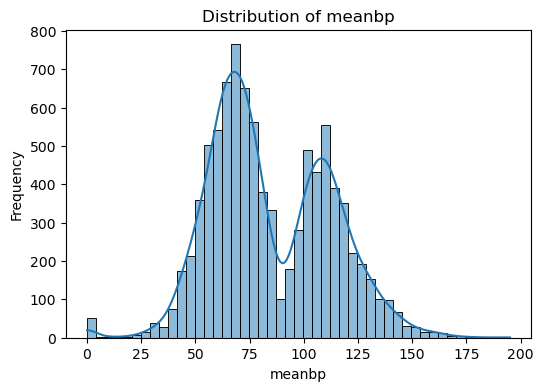

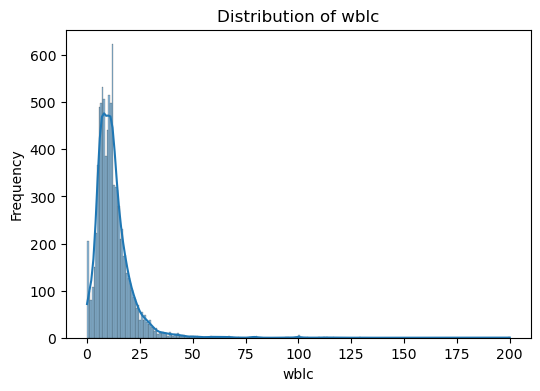

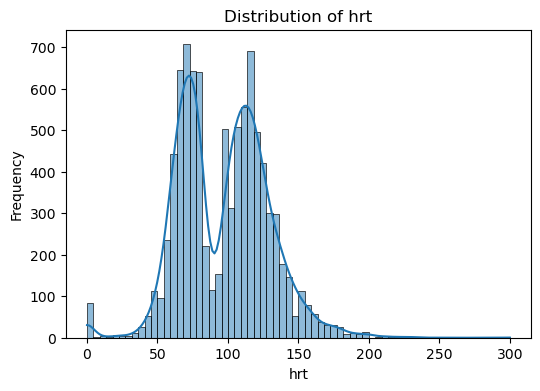

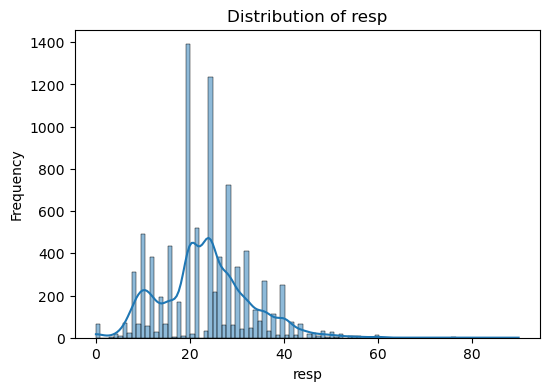

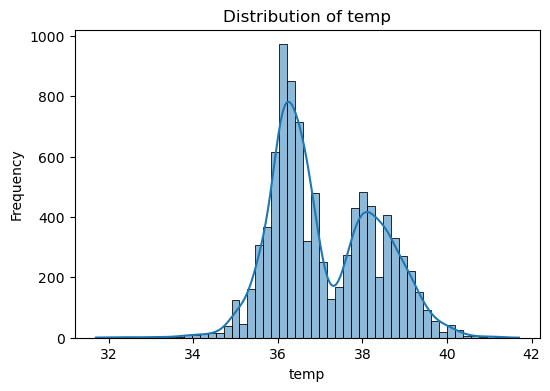

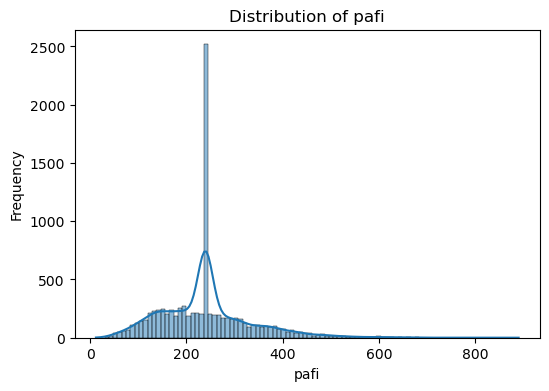

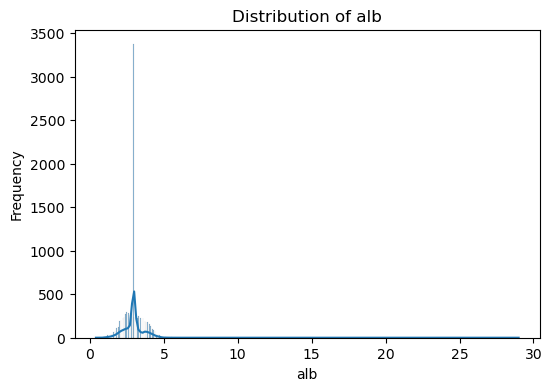

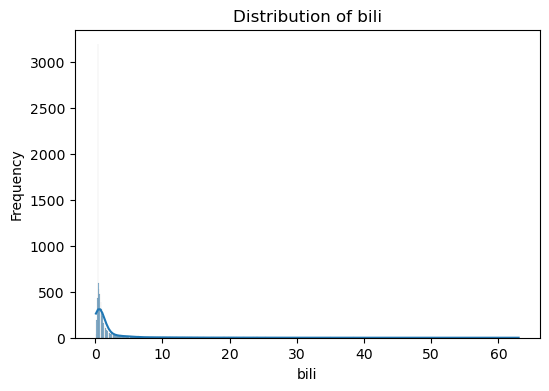

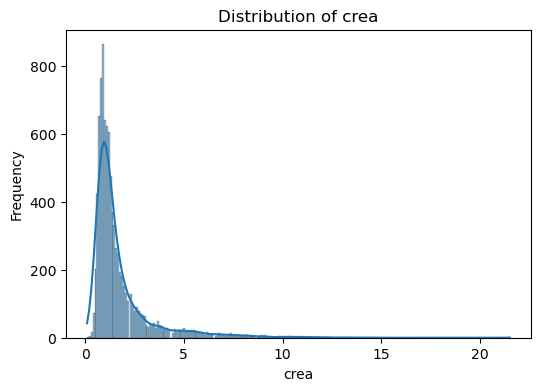

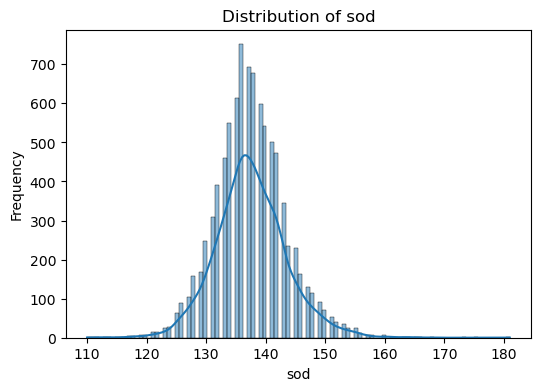

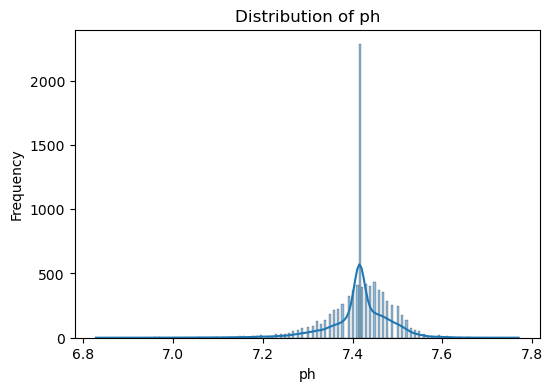

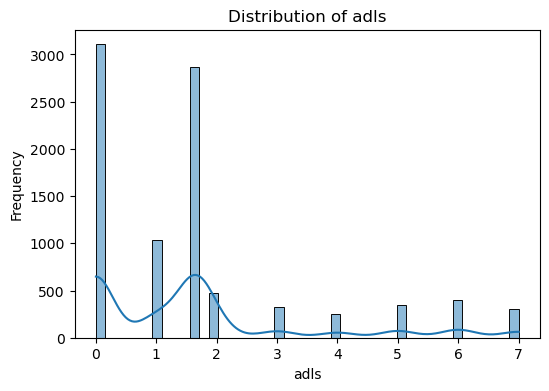

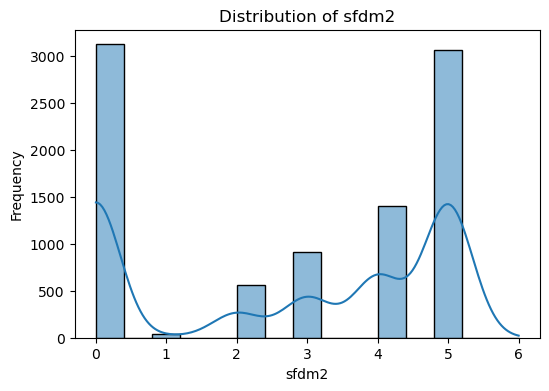

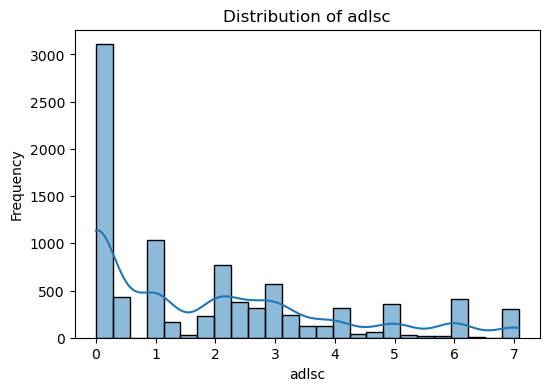

In [90]:
# Load the data from the uploaded file
file_path = './csv/filled_data.csv'
data = pd.read_csv(file_path)

# Display the first few rows to understand the data
data.head()

# Plot histograms for each column to see data distribution
for column in data.columns:
    plt.figure(figsize=(6, 4))
    sns.histplot(data[column], kde=True)
    plt.title(f'Distribution of {column}')
    
    plt.ylabel('Frequency')
    plt.show()

Outliner of feature


--- Column: id ---


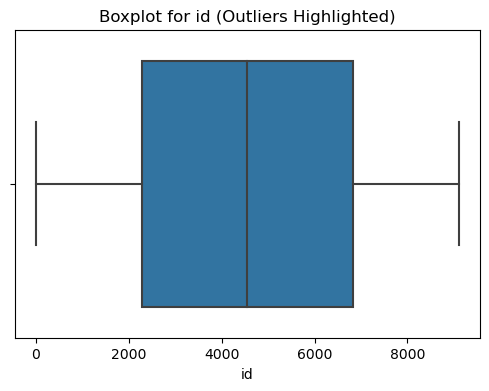


--- Column: age ---


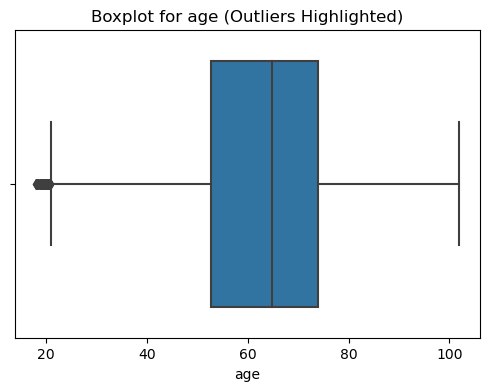


--- Column: slos ---


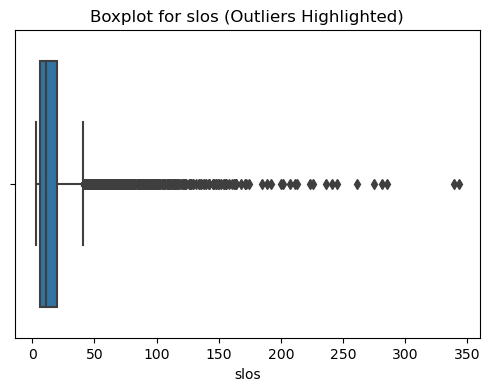


--- Column: d.time ---


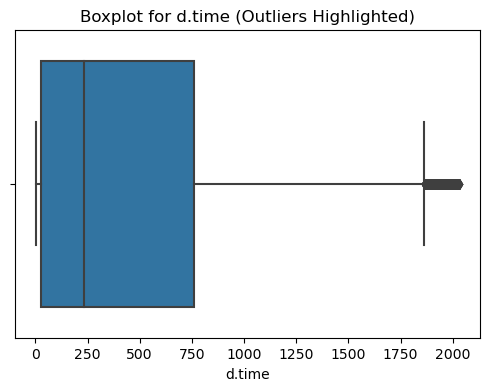


--- Column: dzgroup ---


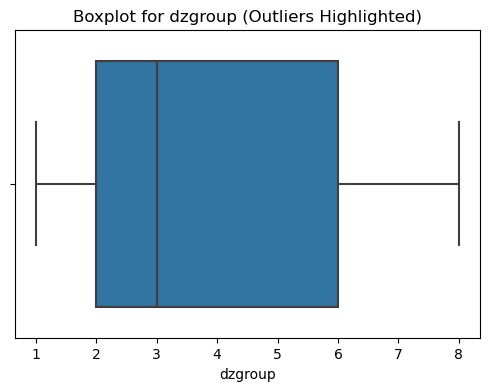


--- Column: dzclass ---


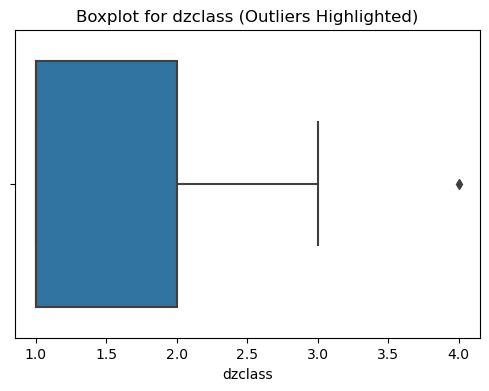


--- Column: num.co ---


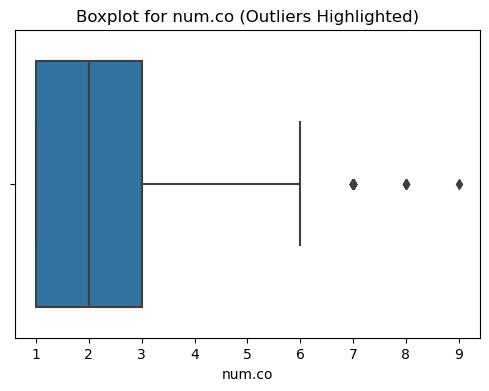


--- Column: edu ---


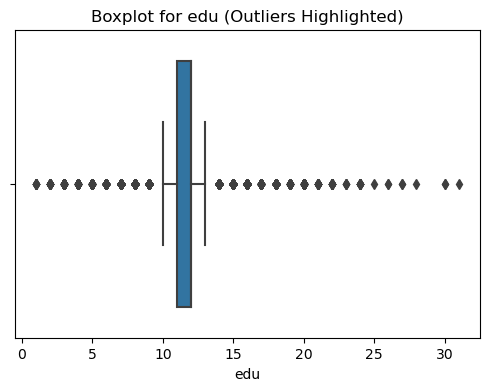


--- Column: income ---


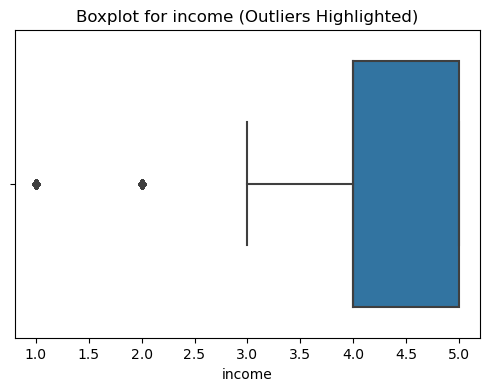


--- Column: scoma ---


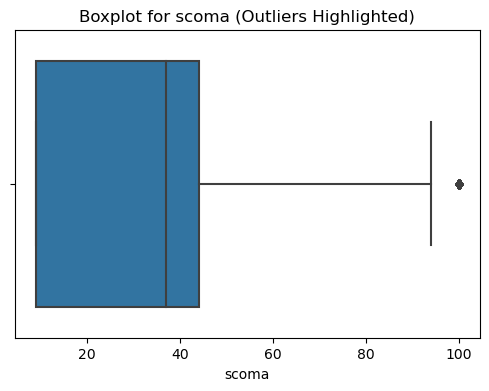


--- Column: totcst ---


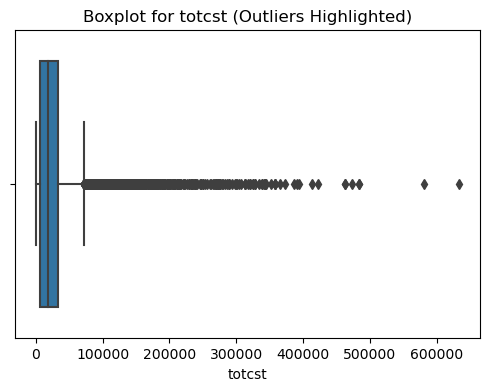


--- Column: totmcst ---


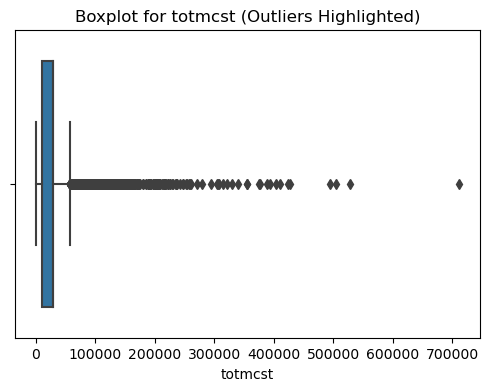


--- Column: avtisst ---


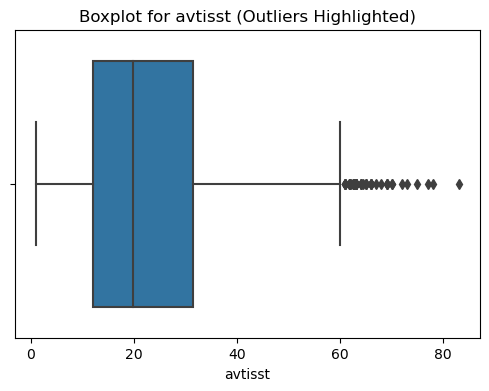


--- Column: race ---


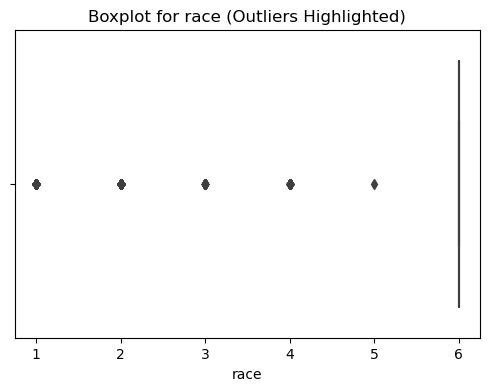


--- Column: sps ---


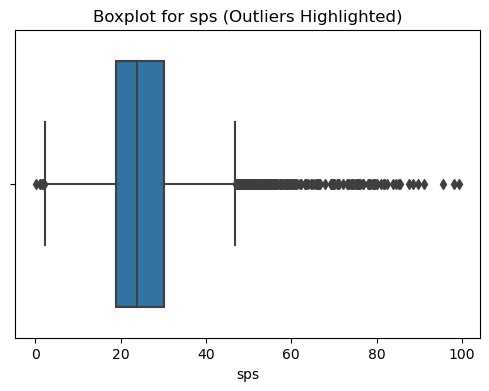


--- Column: aps ---


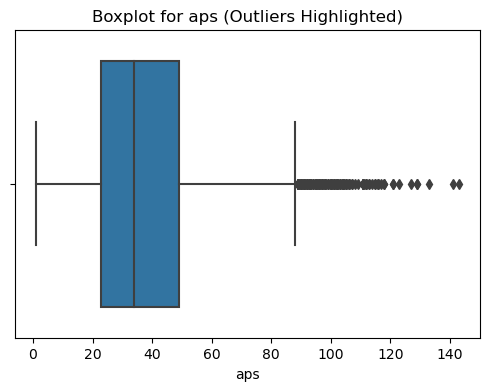


--- Column: surv2m ---


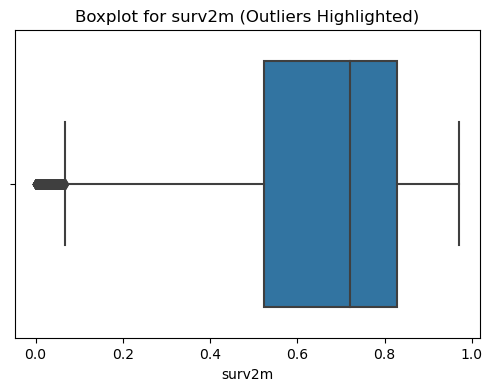


--- Column: surv6m ---


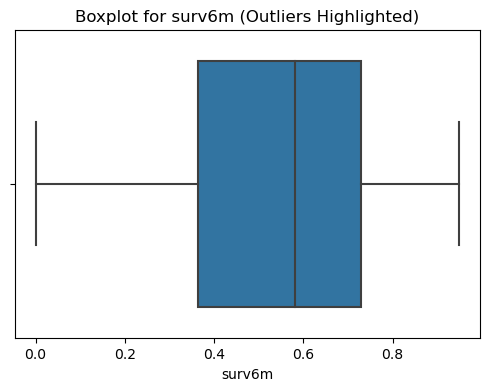


--- Column: hday ---


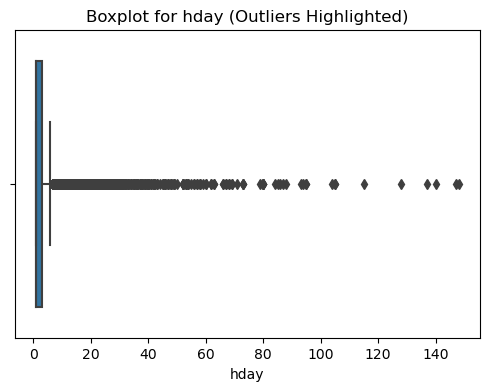


--- Column: ca ---


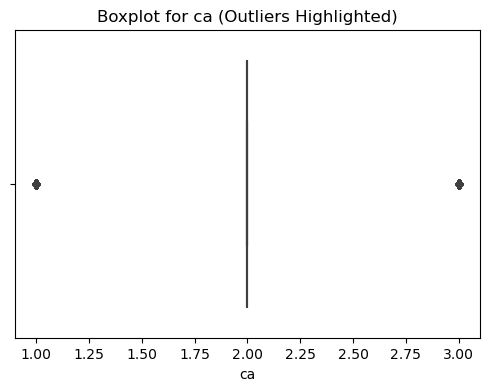


--- Column: prg2m ---


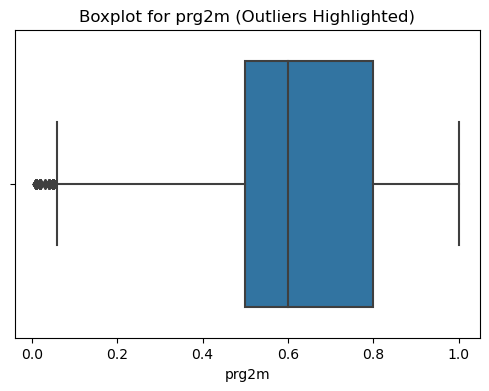


--- Column: prg6m ---


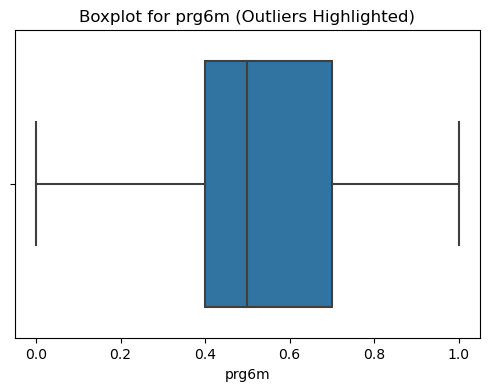


--- Column: dnr ---


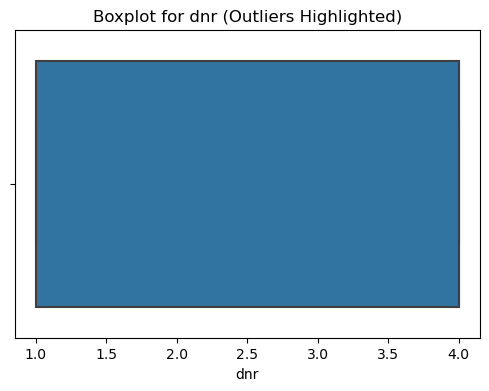


--- Column: dnrday ---


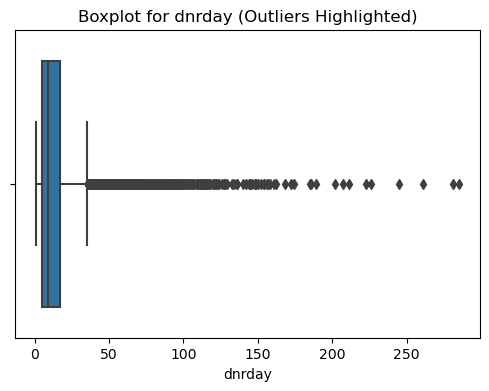


--- Column: meanbp ---


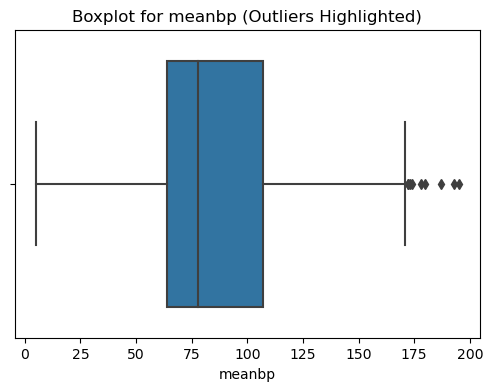


--- Column: wblc ---


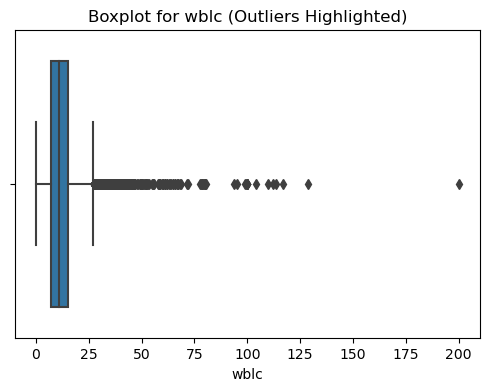


--- Column: hrt ---


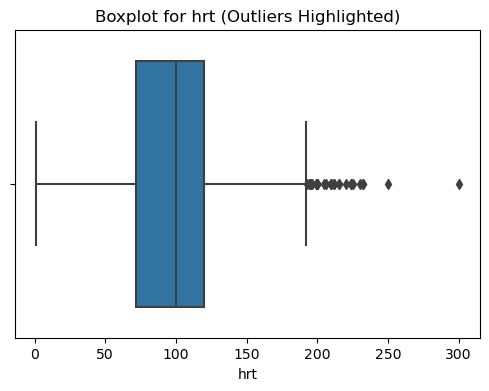


--- Column: resp ---


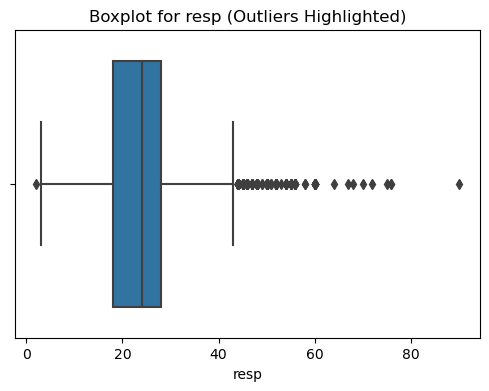


--- Column: temp ---


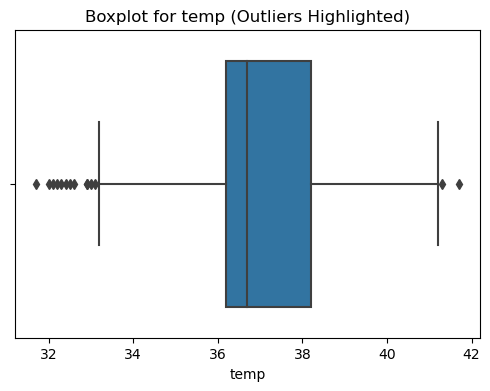


--- Column: pafi ---


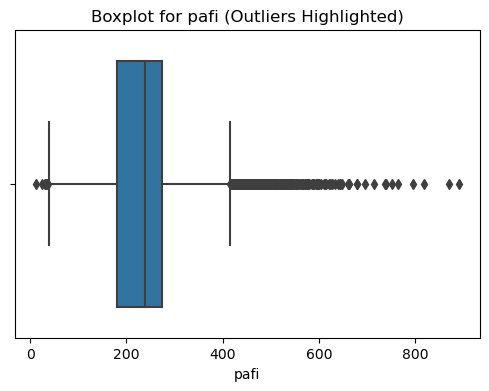


--- Column: alb ---


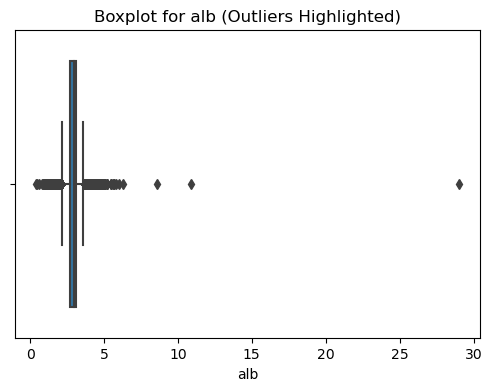


--- Column: bili ---


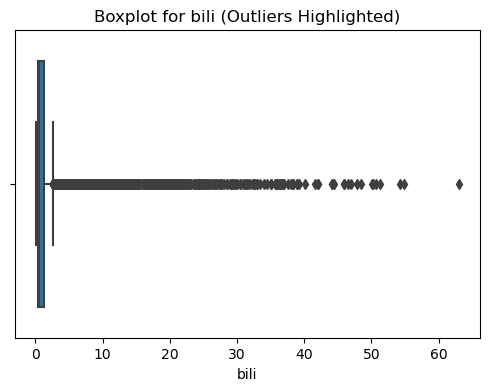


--- Column: crea ---


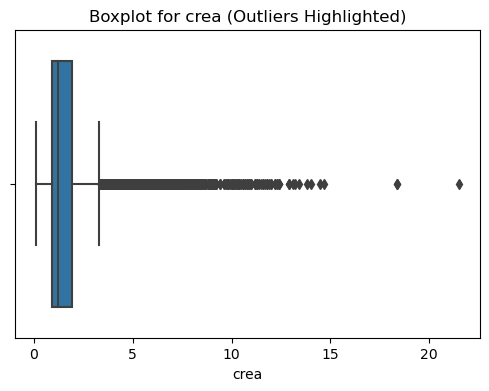


--- Column: sod ---


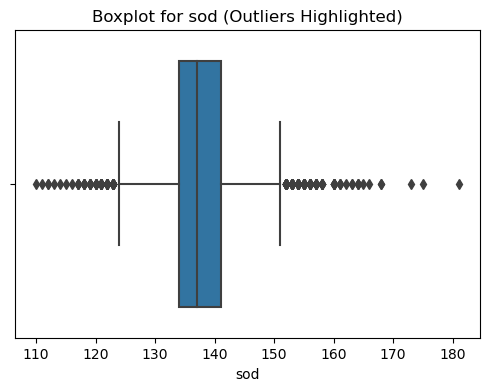


--- Column: ph ---


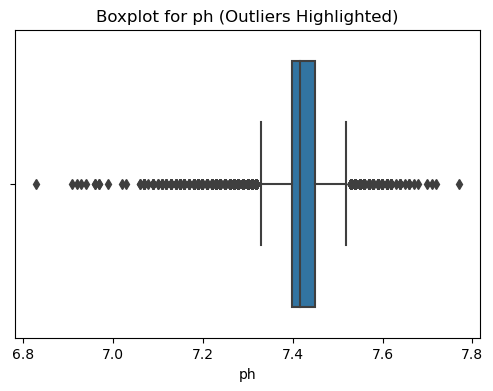


--- Column: adls ---


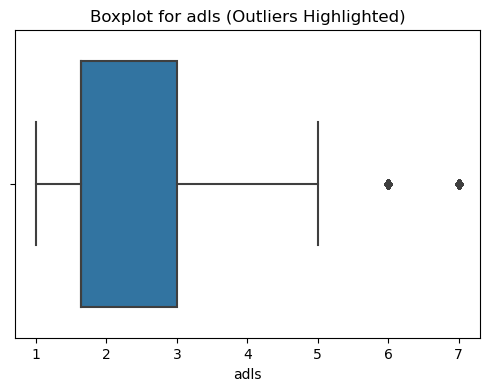


--- Column: sfdm2 ---


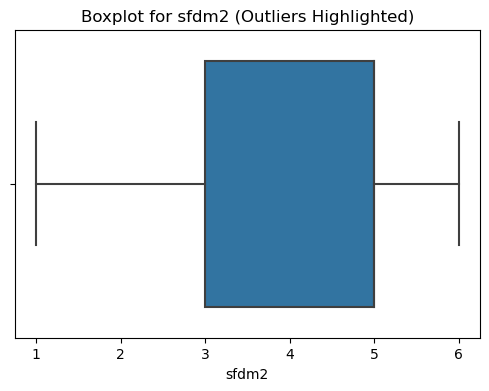


--- Column: adlsc ---


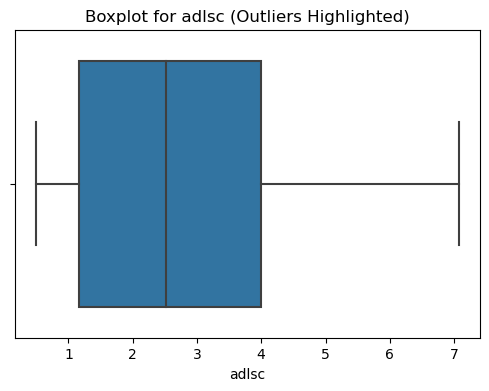


--- Column: charges ---


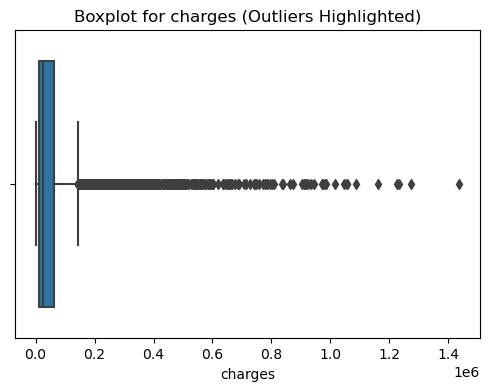

In [91]:
# Load the data from the uploaded file
file_path = './csv/filled_data.csv'
data = pd.read_csv(file_path)

# Display the first few rows to understand the data
data.head()

# Columns to apply transformations 
columns_to_transform = ['id', 'age', 'slos', 'd.time', 'dzgroup',
       'dzclass', 'num.co', 'edu', 'income', 'scoma', 'totcst',
       'totmcst', 'avtisst', 'race', 'sps', 'aps', 'surv2m', 'surv6m', 'hday',
       'ca', 'prg2m', 'prg6m', 'dnr', 'dnrday',
       'meanbp', 'wblc', 'hrt', 'resp', 'temp', 'pafi', 'alb', 'bili', 'crea',
       'sod', 'ph', 'adls', 'sfdm2', 'adlsc','charges']

# Function to plot the boxplot to visualize outliers
def plot_outliers(column_data, column_name):
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=column_data)
    plt.title(f'Boxplot for {column_name} (Outliers Highlighted)')
    plt.xlabel(column_name)
    plt.show()

# Loop through each column and plot outliers
for column in columns_to_transform:
    if column in data.columns:
        print(f"\n--- Column: {column} ---")
        
        # Filter out non-positive values
        data_filtered = data[data[column] > 0][column]

        if len(data_filtered) > 0:
            # Plot the boxplot for outliers
            plot_outliers(data_filtered, column)

        else:
            print(f"Skipping column '{column}' because it has no positive values.")
    else:
        print(f"Column '{column}' not found in the dataset.")

Filter Outliner

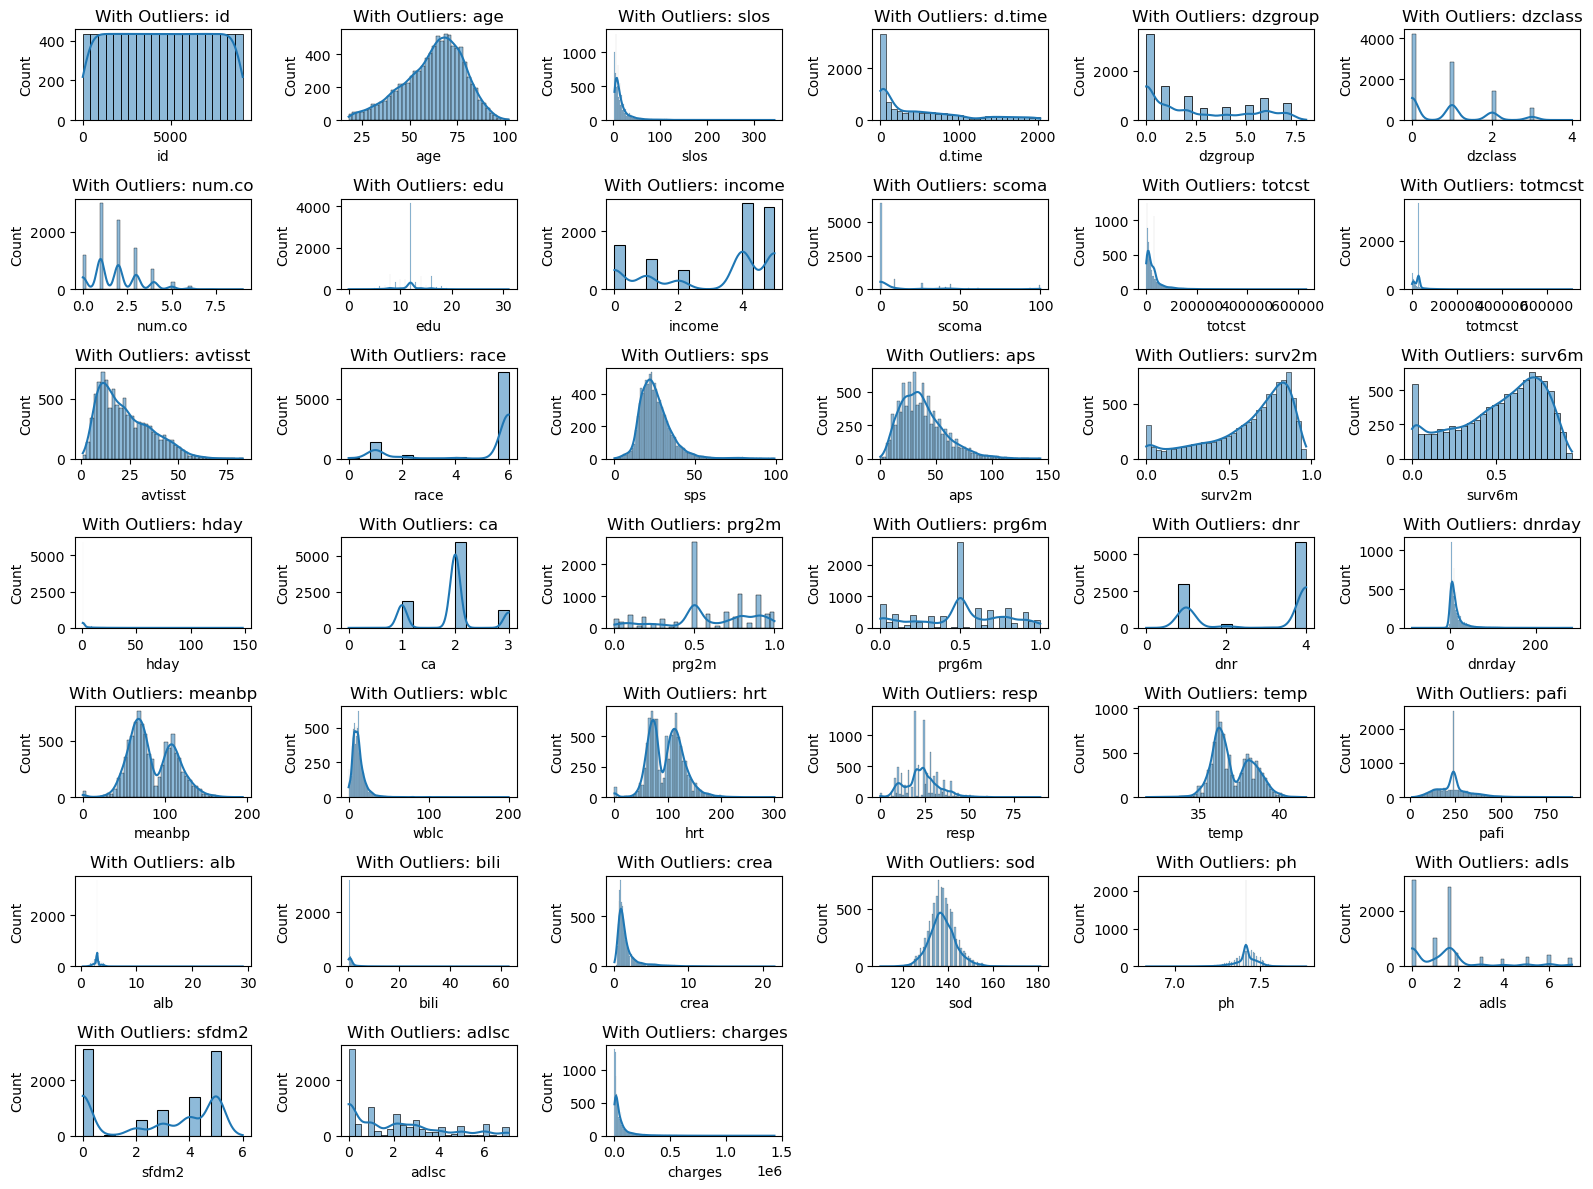

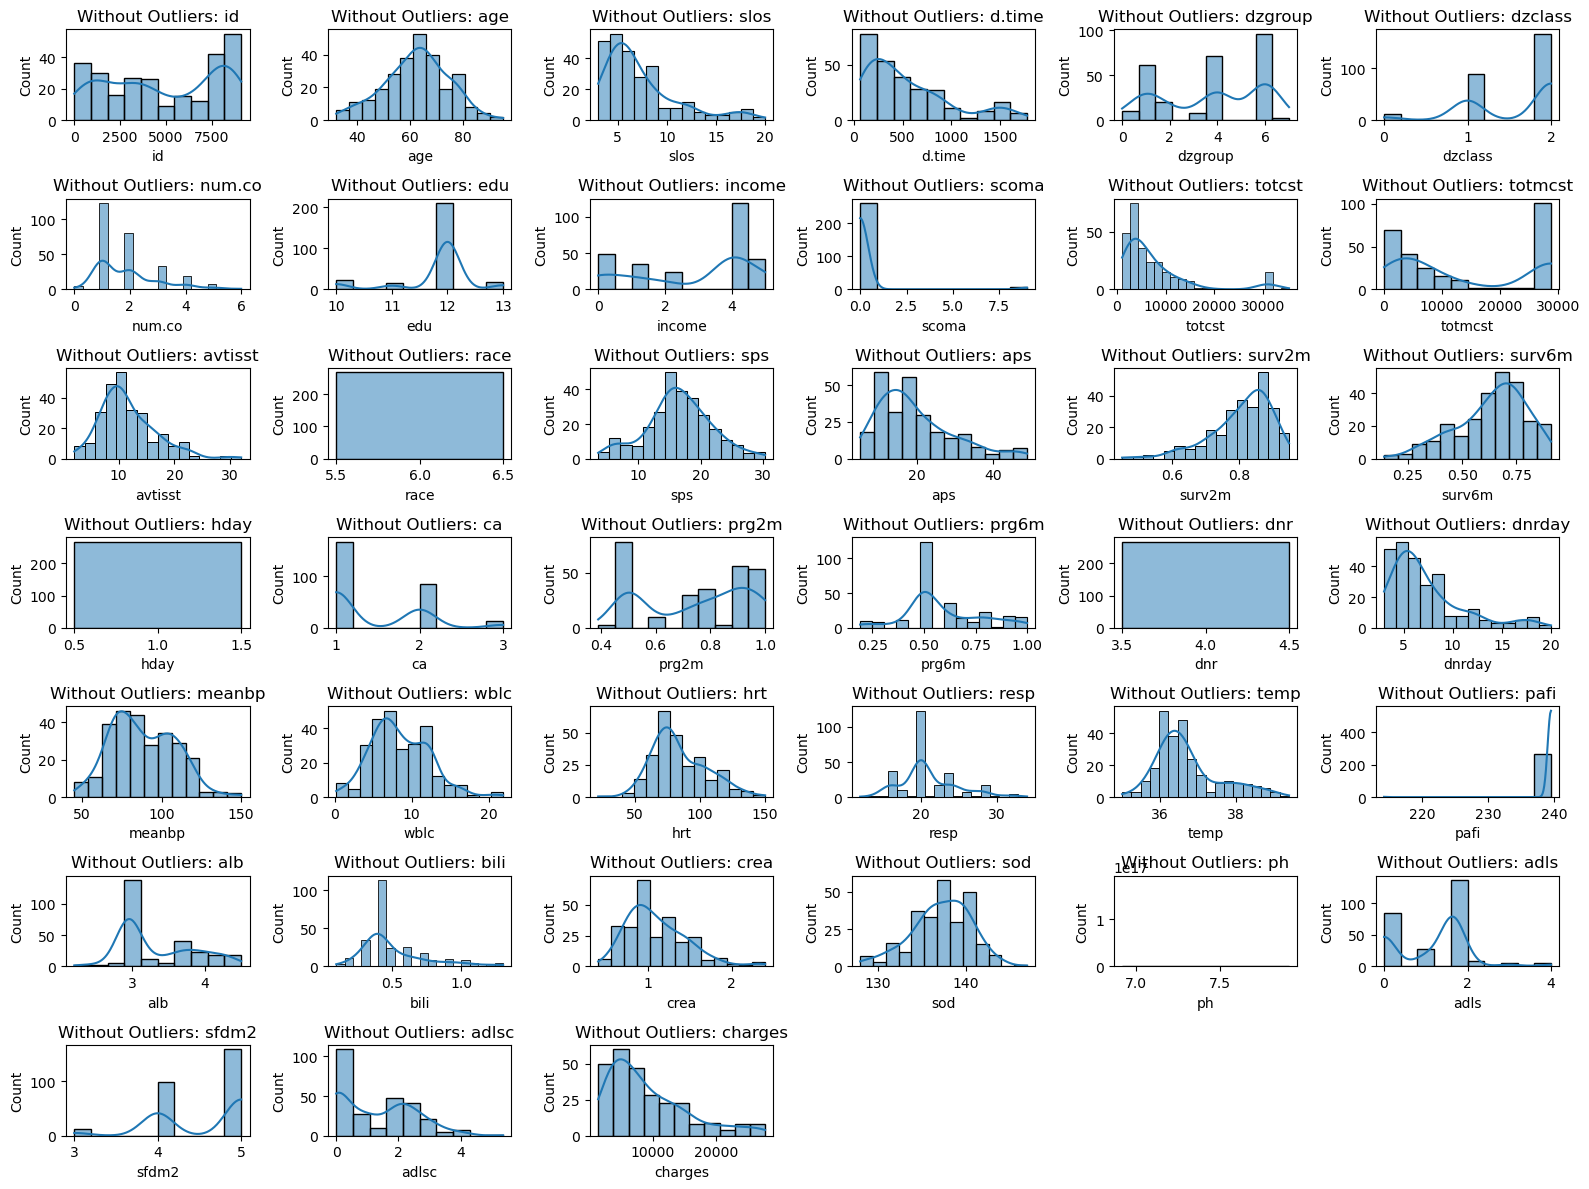

Number of data points before removing outliers: 9104
Number of data points after removing outliers: 268

Completed filling missing values. Results saved to filled_no_outliner.csv


In [94]:
# Load the data from the uploaded file
file_path = './csv/filled_data.csv'
data = pd.read_csv(file_path)

# Columns for demonstration (you can adjust based on your data)
# feature constant (death, sex, hospdead, diabetes, dementia)
feature_columns = ['id', 'age', 'slos', 'd.time', 'dzgroup', 'dzclass', 
                   'num.co', 'edu', 'income', 'scoma', 'totcst', 'totmcst', 
                   'avtisst', 'race', 'sps', 'aps', 'surv2m', 'surv6m', 
                   'hday', 'ca', 'prg2m', 'prg6m', 'dnr', 'dnrday', 'meanbp', 
                   'wblc', 'hrt', 'resp', 'temp', 'pafi', 'alb', 'bili', 
                   'crea', 'sod', 'ph', 'adls', 'sfdm2', 'adlsc','charges']

# Function to detect and remove outliers using IQR
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Calculate the number of rows and columns needed for subplots
n_features = len(feature_columns)
n_cols = 6  # You can adjust the number of columns based on your preference
n_rows = math.ceil(n_features / n_cols)

# 1. Plot data with outliers for all feature columns
plt.figure(figsize=(16, 12))
for i, feature_column in enumerate(feature_columns, 1):
    plt.subplot(n_rows, n_cols, i)  # Adjust the grid based on number of features
    sns.histplot(data[feature_column], kde=True)
    plt.title(f"With Outliers: {feature_column}")
    plt.xlabel(feature_column)

plt.tight_layout()
plt.show()

# 2. Remove outliers for each feature column
data_no_outliers = data.copy()
for feature_column in feature_columns:
    data_no_outliers = remove_outliers_iqr(data_no_outliers, feature_column)

# 3. Plot data without outliers for all feature columns
plt.figure(figsize=(16, 12))
for i, feature_column in enumerate(feature_columns, 1):
    plt.subplot(n_rows, n_cols, i)  # Adjust the grid based on number of features
    sns.histplot(data_no_outliers[feature_column], kde=True)
    plt.title(f"Without Outliers: {feature_column}")
    plt.xlabel(feature_column)

plt.tight_layout()
plt.show()

# Optional: Print the number of data points before and after removing outliers
print(f"Number of data points before removing outliers: {len(data)}")
print(f"Number of data points after removing outliers: {len(data_no_outliers)}")

# บันทึกผลลัพธ์ลงในไฟล์ CSV
output_file = 'filled_no_outliner.csv'
data_no_outliers.to_csv(output_file, index=False)
shutil.move('filled_no_outliner.csv', 'csv')
print(f"\nCompleted filling missing values. Results saved to {output_file}")

Normalize Distribuition


--- Column: id ---

Best transformation for id: Box-Cox (Skewness: -0.37)


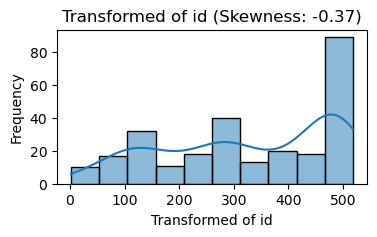

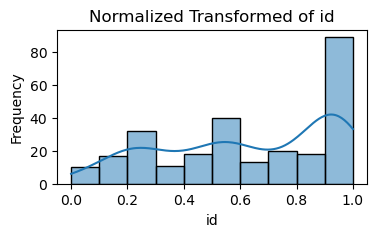


--- Column: age ---

Best transformation for age: Box-Cox (Skewness: -0.02)


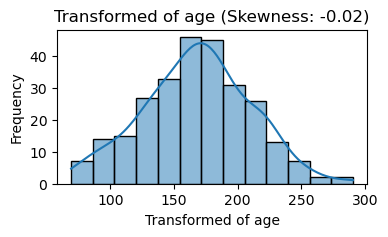

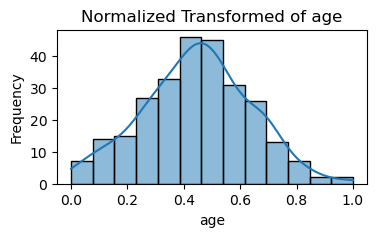


--- Column: slos ---

Best transformation for slos: Box-Cox (Skewness: 0.03)


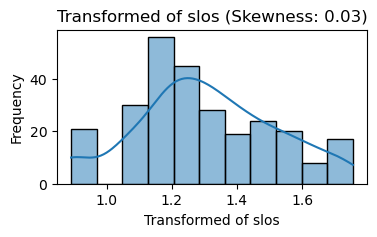

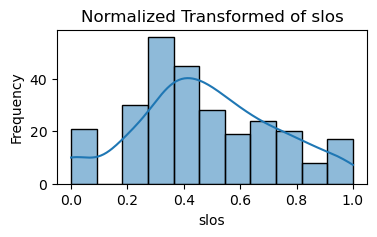


--- Column: d.time ---

Best transformation for d.time: Box-Cox (Skewness: -0.03)


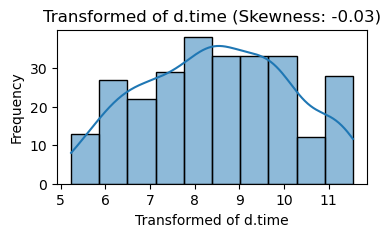

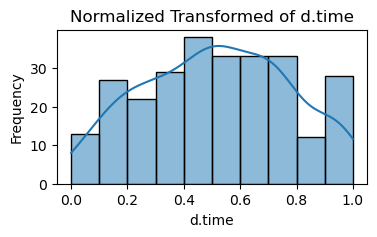


--- Column: dzgroup ---

Best transformation for dzgroup: Box-Cox (Skewness: -0.34)


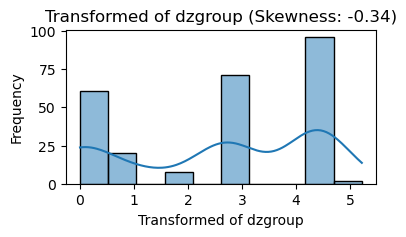

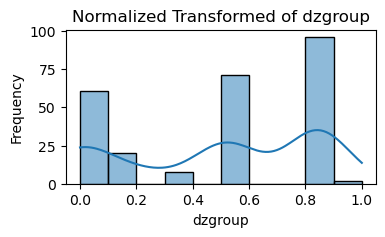


--- Column: dzclass ---

Best transformation for dzclass: Log (Skewness: -0.64)


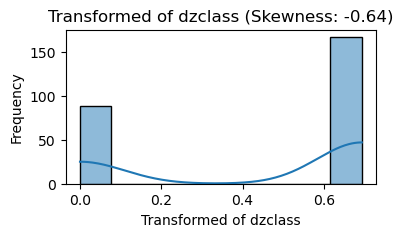

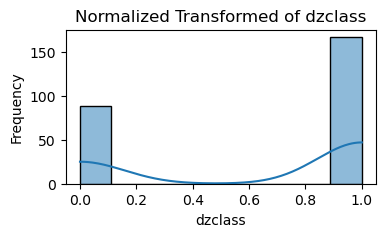


--- Column: num.co ---

Best transformation for num.co: Box-Cox (Skewness: 0.18)


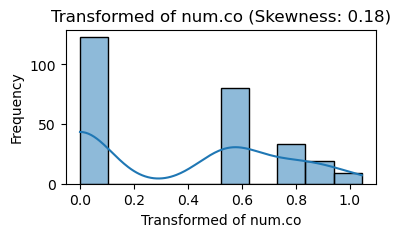

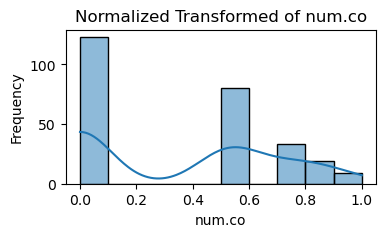


--- Column: edu ---

Best transformation for edu: Box-Cox (Skewness: 0.20)


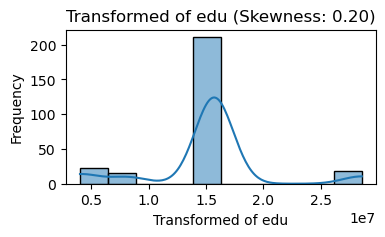

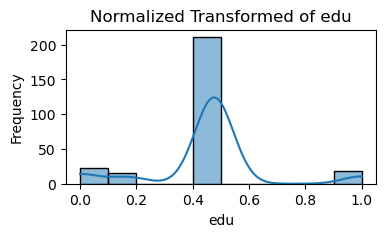


--- Column: income ---

Best transformation for income: Box-Cox (Skewness: -0.52)


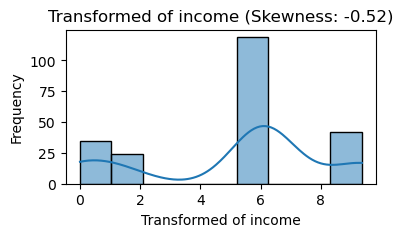

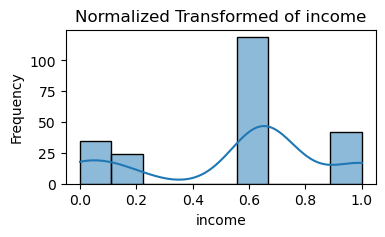


--- Column: totcst ---

Best transformation for totcst: Box-Cox (Skewness: 0.04)


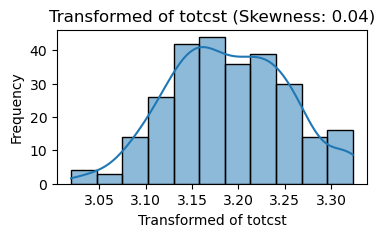

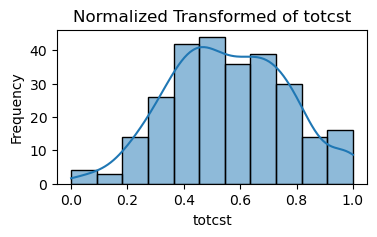


--- Column: totmcst ---

Best transformation for totmcst: Square Root (Skewness: 0.09)


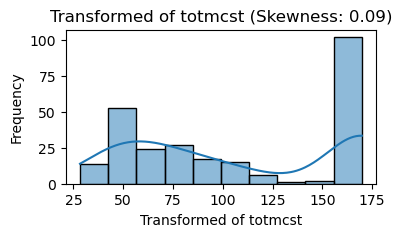

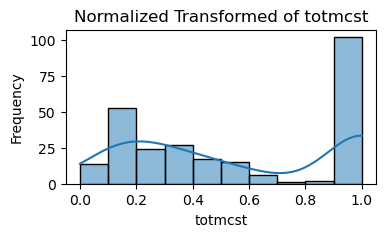


--- Column: avtisst ---

Best transformation for avtisst: Box-Cox (Skewness: 0.03)


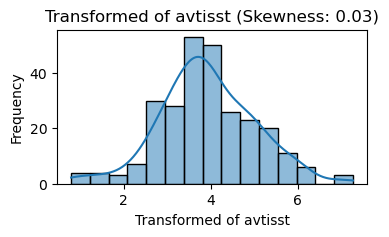

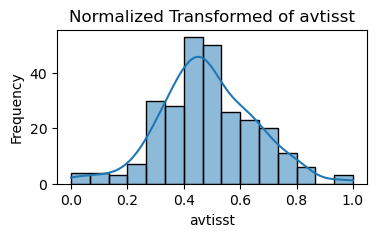


--- Column: sps ---

Best transformation for sps: Box-Cox (Skewness: -0.01)


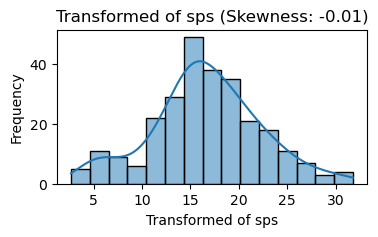

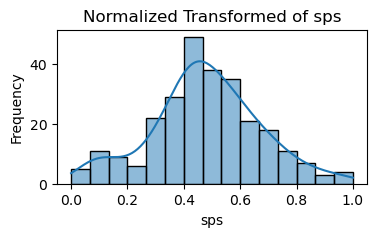


--- Column: aps ---

Best transformation for aps: Box-Cox (Skewness: -0.01)


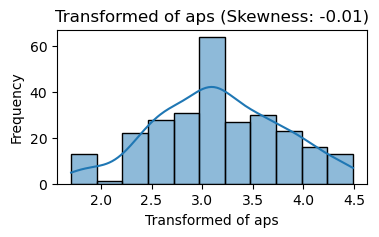

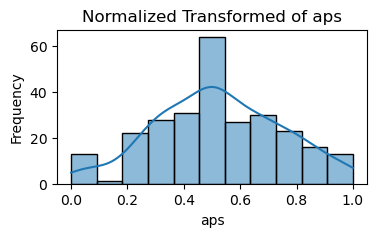


--- Column: surv2m ---

Best transformation for surv2m: Box-Cox (Skewness: -0.15)


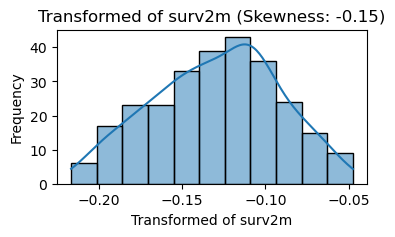

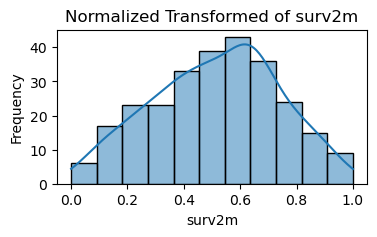


--- Column: surv6m ---

Best transformation for surv6m: Box-Cox (Skewness: -0.17)


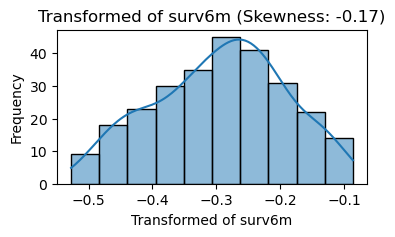

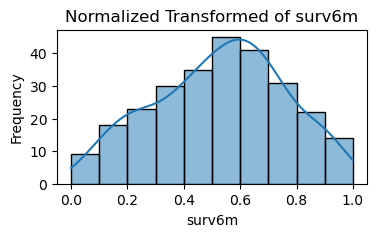


--- Column: ca ---

Best transformation for ca: Box-Cox (Skewness: 0.54)


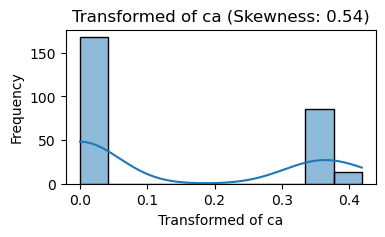

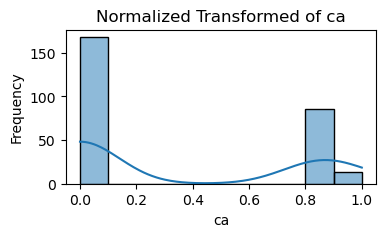


--- Column: prg2m ---

Best transformation for prg2m: Box-Cox (Skewness: -0.19)


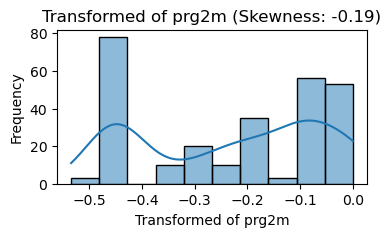

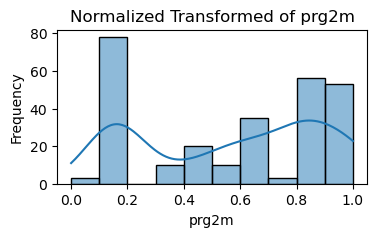


--- Column: prg6m ---

Best transformation for prg6m: Box-Cox (Skewness: 0.02)


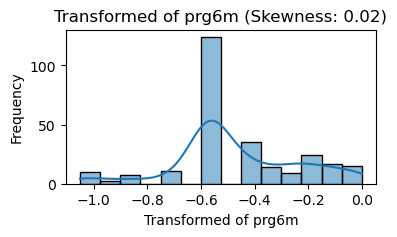

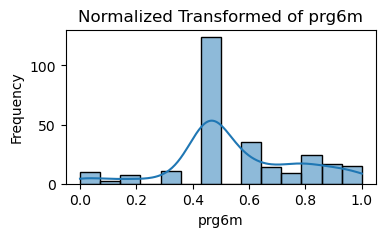


--- Column: dnrday ---

Best transformation for dnrday: Box-Cox (Skewness: 0.03)


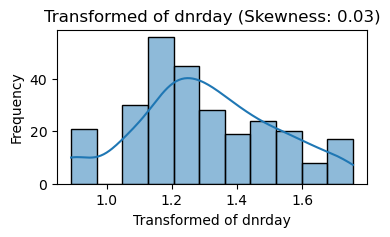

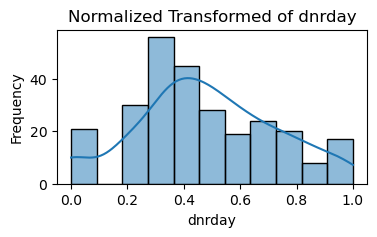


--- Column: meanbp ---

Best transformation for meanbp: Box-Cox (Skewness: -0.01)


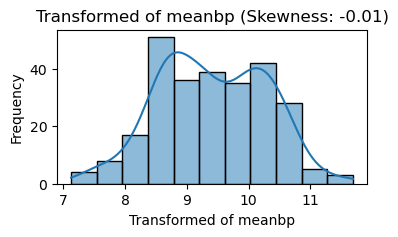

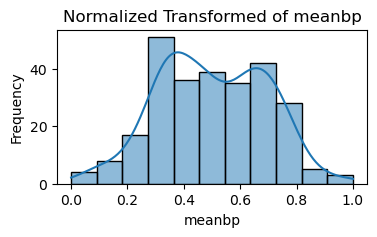


--- Column: wblc ---

Best transformation for wblc: Box-Cox (Skewness: 0.02)


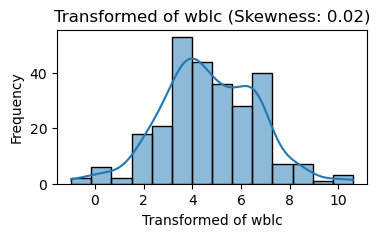

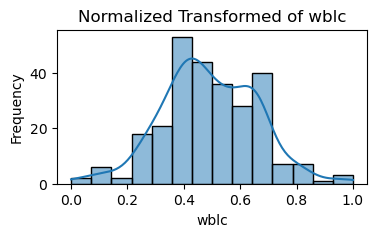


--- Column: hrt ---

Best transformation for hrt: Box-Cox (Skewness: 0.02)


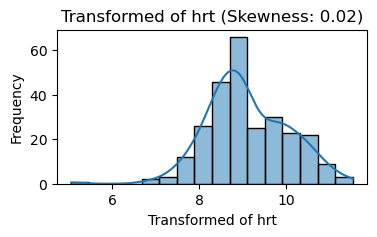

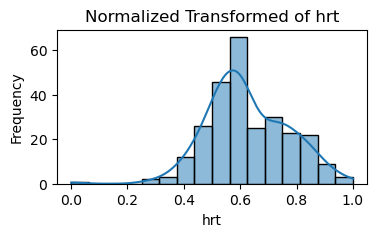


--- Column: resp ---

Best transformation for resp: Box-Cox (Skewness: -0.01)


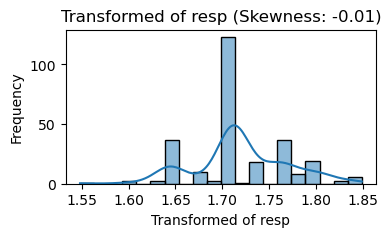

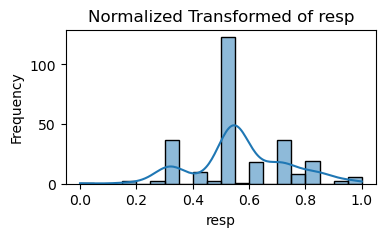


--- Column: temp ---

Best transformation for temp: Box-Cox (Skewness: 0.00)


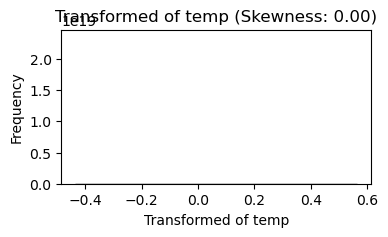

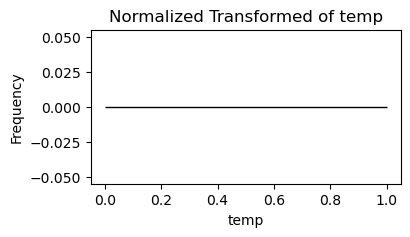


--- Column: alb ---

Best transformation for alb: Box-Cox (Skewness: 0.05)


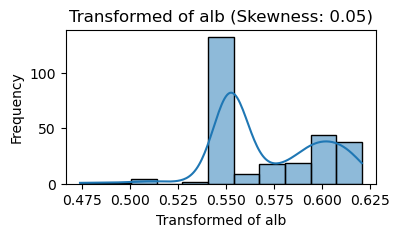

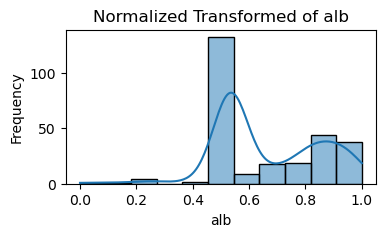


--- Column: bili ---

Best transformation for bili: Box-Cox (Skewness: -0.00)


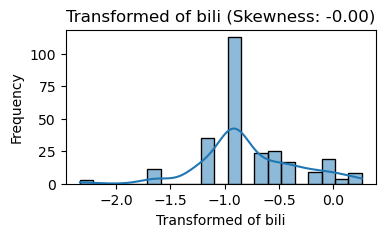

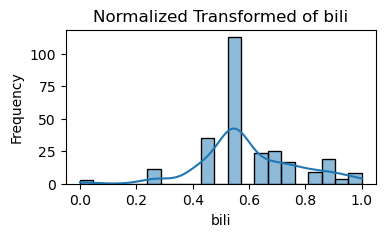


--- Column: crea ---

Best transformation for crea: Box-Cox (Skewness: 0.00)


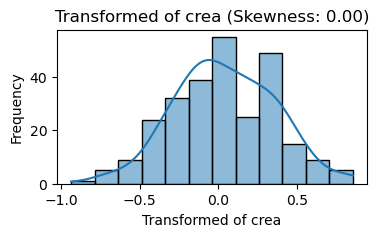

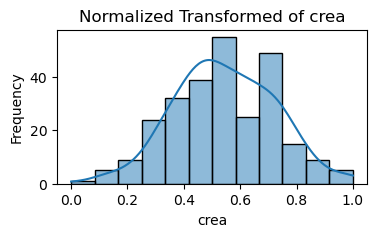


--- Column: sod ---

Best transformation for sod: Box-Cox (Skewness: -0.00)


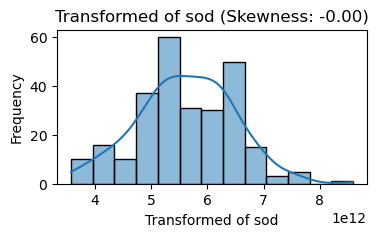

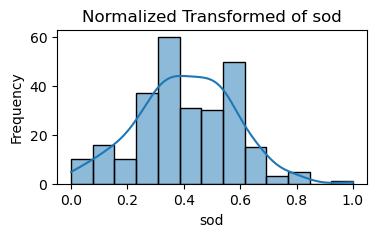


--- Column: adls ---

Best transformation for adls: Box-Cox (Skewness: -0.09)


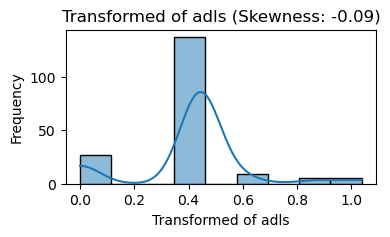

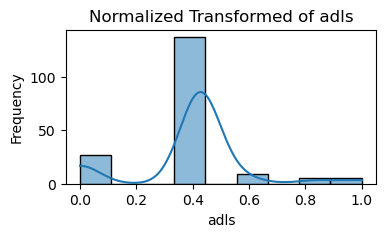


--- Column: sfdm2 ---

Best transformation for sfdm2: Box-Cox (Skewness: -0.44)


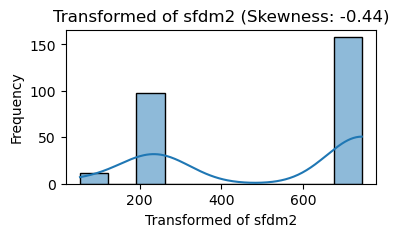

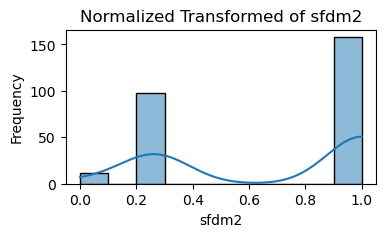


--- Column: adlsc ---

Best transformation for adlsc: Box-Cox (Skewness: -0.10)


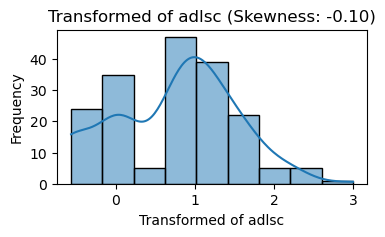

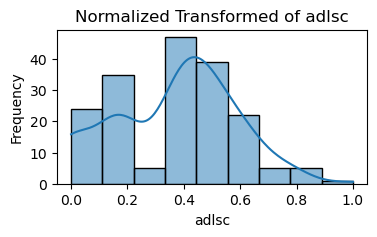


--- Column: charges ---

Best transformation for charges: Box-Cox (Skewness: -0.00)


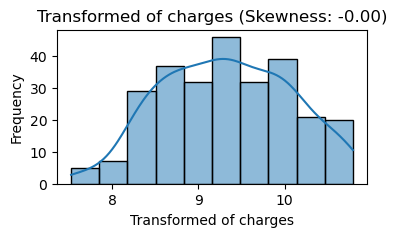

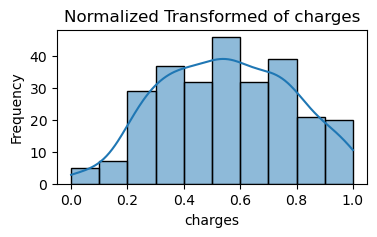

In [95]:
# Load the data from the uploaded file
file_path = './csv/filled_no_outliner.csv'
data = pd.read_csv(file_path)

# Display the first few rows to understand the data
data.head()

# Columns to apply transformations 
columns_to_transform = ['id', 'age', 'slos', 'd.time', 'dzgroup',
       'dzclass', 'num.co', 'edu', 'income', 'totcst',
       'totmcst', 'avtisst', 'sps', 'aps', 'surv2m', 'surv6m',
       'ca', 'prg2m', 'prg6m', 'dnrday',
       'meanbp', 'wblc', 'hrt', 'resp', 'temp', 'alb', 'bili', 'crea',
       'sod', 'adls', 'sfdm2', 'adlsc','charges']

# Function to compute skewness and plot data
def plot_and_evaluate(column_data, title):
    # Calculate skewness
    skewness = column_data.skew()
    
    # Plot the data
    plt.figure(figsize=(4, 2))
    sns.histplot(column_data, kde=True)
    plt.title(f'{title} (Skewness: {skewness:.2f})')
    plt.xlabel(title)
    plt.ylabel('Frequency')
    plt.show()
    
    return skewness


# Function to normalize the data (min-max scaling)
def normalize(column_data):
    return (column_data - column_data.min()) / (column_data.max() - column_data.min())

# Loop through each column and apply transformations
for column in columns_to_transform:
    if column in data.columns:
        print(f"\n--- Column: {column} ---")
        
        # Filter out non-positive values
        data_filtered = data[data[column] > 0][column]

        if len(data_filtered) > 0:

            # 1. Log Transformation (base 10)
            log_transformed_data = np.log(data_filtered)
            log_skewness = log_transformed_data.skew()
            
            # 2. Square Root Transformation
            sqrt_transformed_data = np.sqrt(data_filtered)
            sqrt_skewness = sqrt_transformed_data.skew()
            
            # 3. Box-Cox Transformation
            # can't use in data constant (scoma, race, hday, dnr, pafi, ph)
            boxcox_transformed_data, _ = stats.boxcox(data_filtered)
            boxcox_skewness = pd.Series(boxcox_transformed_data).skew()
            
            # Choose the best transformation based on skewness (closer to 0 means better)
            skewness_values = {
                'Log': log_skewness,
                'Square Root': sqrt_skewness,
                'Box-Cox': boxcox_skewness
            }
            best_transformation = min(skewness_values, key=lambda k: abs(skewness_values[k]))
            
            print(f"\nBest transformation for {column}: {best_transformation} (Skewness: {skewness_values[best_transformation]:.2f})")

            # Plot the best transformation data
            if best_transformation == 'Log':
                best_transformed_data = log_transformed_data
            elif best_transformation == 'Square Root':
                best_transformed_data = sqrt_transformed_data
            elif best_transformation == 'Box-Cox':
                best_transformed_data = pd.Series(boxcox_transformed_data)

            # Plot the best transformation
            plot_and_evaluate(best_transformed_data, f'Transformed of {column}')
            
            # Normalize the best transformation data
            normalized_data = normalize(best_transformed_data)

            # Plot the normalized data
            plt.figure(figsize=(4, 2))
            sns.histplot(normalized_data, kde=True)
            plt.title(f'Normalized Transformed of {column}')
            plt.xlabel(f'{column}')
            plt.ylabel('Frequency')
            plt.show()

        else:
            print(f"Skipping column '{column}' because it has no positive values.")
    else:
        print(f"Column '{column}' not found in the dataset.")


Target Factory

Target : Charges

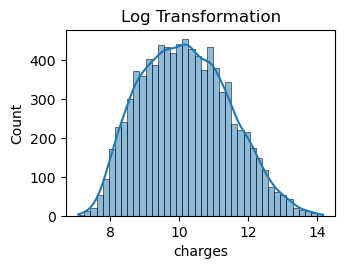

In [30]:

log_transformed = np.log1p(target_variable)  # ใช้ np.log1p เพื่อหลีกเลี่ยง log(0) ที่ไม่กำหนดค่า
plt.subplot(2, 2, 2)
sns.histplot(log_transformed, kde=True)
plt.title('Log Transformation')

plt.tight_layout()
plt.show()

Square root transformation

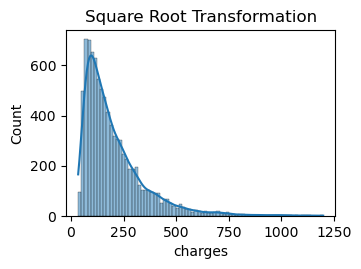

In [31]:
sqrt_transformed = np.sqrt(target_variable)
plt.subplot(2, 2, 3)
sns.histplot(sqrt_transformed, kde=True)
plt.title('Square Root Transformation')

plt.tight_layout()
plt.show()

Box-Cox Transformation

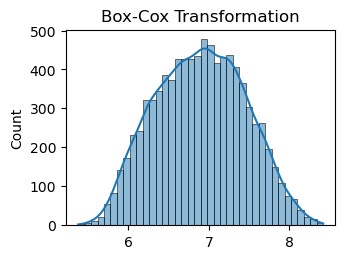

In [32]:
target_variable = target_variable.dropna()
target_variable = target_variable[target_variable > 0]

target_variable_positive = target_variable + 0.001
boxcox_transformed, _ = boxcox(target_variable_positive)
plt.subplot(2, 2, 4)
sns.histplot(boxcox_transformed, kde=True)
plt.title('Box-Cox Transformation')

plt.tight_layout()
plt.show()

Normalization Min-Max

In [33]:
# Normalize the log-transformed values
scaler = MinMaxScaler()
log_transformed_normalized = scaler.fit_transform(log_transformed.values.reshape(-1, 1))

# Add normalized log-transformed charges to the dataframe
df['log_transformed_normalized'] = log_transformed_normalized

# Plot
plt.figure(figsize=(14, 7))

plt.subplot(2, 2, 1)
sns.histplot(df['charges'], kde=True)
plt.title('Original Charges')

plt.subplot(2, 2, 2)
sns.histplot(log_transformed, kde=True)
plt.title('Log Transformation')

plt.subplot(2, 2, 3)
sns.histplot(log_transformed_normalized, kde=True)
plt.title('Normalized Log-transformed Charges')

plt.tight_layout()
plt.show()

ValueError: Length of values (9106) does not match length of index (9103)

Feature Selection
1. Filter Method (Correlation Matrix)

In [20]:
# Compute the correlation matrix
correlation_matrix = df.corr()

# Compute correlation with the target variable
target_correlation = correlation_matrix['charges'].abs().sort_values(ascending=False)

# Select features with high correlation with the target variable
high_correlation_features = target_correlation[target_correlation > 0.1].index
print(high_correlation_features)

KeyError: 'charges'